In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from astropy.constants import G
import astropy.units as u
import seaborn as sns
from tqdm import tqdm
import os

In [2]:
def search_closest_upper(value, array):
    diff = array - value
    return np.where(diff >= 0)[0][0]

In [3]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
apx_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()

In [3]:
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
apx_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
#apx_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1_no-shield/box_2_z_1_no-shield_run2/halotree_1088_final.npy', allow_pickle=True).tolist()

In [4]:
time_list = np.array([ray_tree['0'][key]['time'] for key in ray_tree['0'].keys()])
idx_list = np.array([int(key) for key in ray_tree['0'].keys()])

In [5]:
ray_halo_wstars = {}
apx_halo_wstars = {}

In [7]:
idx = '170'

ray_halo_wstars_pos = np.empty(shape=(0,3))
ray_halo_wstars_rvir = np.array([])
ray_halo_wstars_branch = np.array([])
#ray_halo_wstars_dmmass = np.empty(shape=(0,1))

for key, vals in ray_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        ray_halo_wstars[key] = vals[idx]
        ray_halo_wstars_pos = np.vstack((ray_halo_wstars_pos, vals[idx]['coor']))
        ray_halo_wstars_rvir = np.append(ray_halo_wstars_rvir, vals[idx]['Rvir'])
        ray_halo_wstars_branch = np.append(ray_halo_wstars_branch, key)
        
for key, vals in apx_tree.items():
    if idx in vals.keys() and vals[idx]['star_mass'] > 1:
        apx_halo_wstars[key] = vals[idx]

In [8]:
#Locate the overlapping halos. 
#For these halos, the stellar mass from the Thinh_structure file can be double counted. Therefore, we need to uniquely assign stars to each halo rather than loading the whole yt region.
overlap_pair = []
for i in range(len(ray_halo_wstars_branch)):
    for j in range(len(ray_halo_wstars_branch)):
        if (i == j) or sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]) in overlap_pair:
            continue
        else:
            if np.linalg.norm(ray_halo_wstars_pos[i] - ray_halo_wstars_pos[j]) < (ray_halo_wstars_rvir[i] + ray_halo_wstars_rvir[j]): #overlapping condition
                overlap_pair.append(sorted([ray_halo_wstars_branch[i],ray_halo_wstars_branch[j]]))

overlap_group = []
for pair in overlap_pair:
    if pair == overlap_pair[0]:
        group = pair
    else:
        if (pair[0] in group) or (pair[1] in group):
            group = list(set(group + pair))
        else:
            overlap_group.append(group)
            group = pair

In [9]:
#These are the groups of halos that need to be disentangled in terms of stellar mass
overlap_group

[['0_20', '0_21', '0', '0_16', '0_18', '0_19', '0_4', '0_2'],
 ['1', '1_14', '1_10'],
 ['3_1', '3', '3_7'],
 ['5', '5_1']]

In [76]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [79]:
group_test = np.array(overlap_group[0])
group_velcom = np.array([ray_rawtree[group_i][int(idx)]['Vel_Com'] for group_i in group_test])
#convert the unit of halo velocity from code_length/s to km/s
ds = yt.load(ray_pfs[int(idx)])
group_velcom = (group_velcom*ds.units.code_length/ds.units.s).to('km/s').v
group_starID = {}
allstars = []
for halo in group_test:
    halo_center = ray_tree[halo][idx]['coor']
    halo_radius = ray_tree[halo][idx]['Rvir']
    boolean = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_radius
    group_starID[halo] = ray_ID_all[boolean].astype(int)
    allstars = list(set(allstars + list(ray_ID_all[boolean].astype(int))))
allstars = np.array(group_allstars)

yt : [INFO     ] 2024-12-10 10:23:52,751 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2024-12-10 10:23:52,752 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-10 10:23:52,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-10 10:23:52,762 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-10 10:23:52,765 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-10 10:23:52,768 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2024-12-10 10:23:52,770 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-10 10:23:52,773 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-10 10:23:52,774 Parameters: hubble_constant           = 0.679


In [32]:
group_starID

{'0_20': array([65363538, 65364102, 65364638, 65364670, 65364748]),
 '0_21': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
        65734358, 65734359, 65734360, 65734362, 65734363, 65734364,
        65734366]),
 '0': array([65363541, 65363542, 65364086, ..., 65665931, 65665937, 65724384]),
 '0_16': array([65363537, 65363546, 65363851, ..., 65665931, 65665937, 65724384]),
 '0_18': array([65363541, 65363542, 65364086, 65364088, 65364194, 65364698,
        65364664, 65364679, 65364681, 65614185, 65614414, 65617205,
        65659343, 65363652, 65363539, 65363540, 65363665, 65363673,
        65363674, 65363767, 65363773]),
 '0_19': array([65363541, 65363542, 65364086, 65364113, 65364693, 65364695,
        65364700, 65363652, 65363826, 65363539, 65363540, 65363665,
        65363673, 65363683, 65363767, 65363773, 65363831, 65364106]),
 '0_4': array([65364088, 65364194, 65364127, 65364129]),
 '0_2': array([65731297, 65734353, 65734354, 65734355, 65734356, 65734357,
       

In [33]:
allstars

array([65732608, 65658881, 65658882, ..., 65363965, 65724414, 65732607])

In [46]:
count_list = {}
for ID in allstars:
    count = 0
    branch_overlap = []
    for branch in group_starID.keys():
        if ID in group_starID[branch]:
            count += 1
            branch_overlap.append(branch)
    if count > 1:
        count_list[ID] = [count, branch_overlap]

In [85]:
ray_vel_all[ray_ID_all == 65732608]

array([[-65.81759841,  12.10400267, 120.21314368]])

In [90]:
ray_rawtree['0'][171]

{'NumParts': 10324,
 'Halo_Mass': 7628372984.201647,
 'Halo_Radius': 0.003219896406693052,
 'cden': 202.11934833096655,
 'r100': 0.0038463181360783145,
 'r150': 0.0036909953190874156,
 'r200': 0.003237456954225626,
 'r250': 0.0028894798550874417,
 'r300': 0.0026477752928777674,
 'r500': 0.0020518783497319,
 'r700': 0.001687430599046631,
 'Halo_Center': array([0.49444511, 0.50351903, 0.51216658]),
 'Vel_Com': array([-7.90055792e-19, -4.80827245e-20,  1.03378648e-19])}

In [86]:
count_list[65732608]

[2, ['0', '0_16']]

In [88]:
group_velcom[group_test == '0']

array([[-35.6028203 ,  -4.23333669,  10.90924301]])

In [89]:
group_velcom[group_test == '0_16']

array([[  8.91740217, -44.69326534,  60.8857723 ]])

In [65]:
group_test

['0_20', '0_21', '0_4', '0_16', '0', '0_18', '0_19', '0_2']

In [14]:
ray_pos_all.shape

(30056, 3)

In [17]:
ray_halo_wstars_pos

array([[0.49420246, 0.50316925, 0.51266823],
       [0.49296721, 0.50155015, 0.51324955],
       [0.47673882, 0.50389487, 0.5022506 ],
       [0.48908694, 0.50969391, 0.50063493],
       [0.50191681, 0.51200992, 0.53478709],
       [0.50191068, 0.51098171, 0.53401179],
       [0.50015472, 0.49932791, 0.512181  ],
       [0.48527808, 0.4967556 , 0.51121502],
       [0.50025661, 0.50790924, 0.53018027],
       [0.49264434, 0.51777617, 0.49249299],
       [0.48658425, 0.52111066, 0.52580045],
       [0.5022803 , 0.51522828, 0.53829083],
       [0.50312778, 0.51599952, 0.53952004]])

In [21]:
ray_halo_wstars.keys()

dict_keys(['0', '0_2', '1', '3', '4', '4_0', '5', '6', '8', '9', '18', '20', '69'])

In [22]:
ray_halo_wstars['0_2']

{'tree_loc': '0_2',
 'coor': array([0.49296721, 0.50155015, 0.51324955]),
 'Rvir': 0.0014047493591527603,
 'redshift': 10.886019680253,
 'time': 0.42308436376385633,
 'gas_mass': 170519124.77518892,
 'gas_mass_frac': 0.12780071866170767,
 'h2_mass': 5220394.575481022,
 'h2_fraction': 0.030614715987802243,
 'dm_mass': 1162249229.1687708,
 'pop2_mass': 1489589.9787338013,
 'pop3_mass': 5.17818883535532,
 'star_mass': 1489595.1569226366,
 'metal_mass': 14570.536272090665,
 'metallicity': 8.544810613648377e-05,
 'sfr': 0.0,
 'total_mass': 1334257949.1008823}

We need to assign each star to a unique halo. This can be done by tracking back the star's position when it first forms to see if it forms inside the same halo

In [8]:
ray_halo_idx = '0'
ray_halo_center = ray_tree[ray_halo_idx][idx]['coor']
ray_halo_rvir = ray_tree[ray_halo_idx][idx]['Rvir']

In [9]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())

In [10]:
halo_star_pos = ray_pos_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_age = ray_age_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]
halo_star_ID = ray_ID_all[np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir]

In [15]:
ftime_dict = {}
for j in range(len(halo_star_age)):
    ftime = time_list[-1] - halo_star_age[j]
    ftime_snapidx = idx_list[search_closest_upper(ftime, time_list)]
    try:
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))
    except:
        ftime_dict[ftime_snapidx] = []
        ftime_dict[ftime_snapidx].append(int(halo_star_ID[j]))

In [18]:
ftime_dict.keys()

dict_keys([80, 95, 117, 122, 124, 125, 154, 158, 159, 176, 190, 193, 194, 195, 201, 203, 130, 79, 156, 163, 198, 199, 114, 118, 200, 99, 109, 111, 112, 116, 119, 120, 121, 123, 127, 129, 131, 133, 134, 137, 138, 139, 141, 142, 143, 144, 160, 161, 175, 184, 202, 126, 150, 152, 162, 164, 169, 170, 174, 177, 178, 179, 183, 187, 191, 192, 204, 165, 180, 205, 206, 207, 208, 182, 209, 210, 211])

### Star Assignment Technique by Thinh

Starting from the earlier snapshot to the later snapshot. If a star particle is formed in a halo, assume that it will not escape that halo (there is a chance that during fly by, a DM halo can still some star particles, but since we are investigating star formation in halo, this can be neglected). If that halo is a sub branch, the star particle will belong to the main branch at the time step of merging. If a star particle is formed between the region of multiple halos, use energy definition to determine which halo it belongs to (choose the halo in which the star particle has the lowest total energy)

In [5]:
ray_tree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final_Thinh_structure.npy', allow_pickle=True).tolist()
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [6]:
output = {}
for idx in ray_tree['0'].keys():
    output[str(idx)] = {}

In [7]:
def list_of_halos_wstars_idx(tree, idx):
    halo_wstars_pos = np.empty(shape=(0,3))
    halo_wstars_rvir = np.array([])
    halo_wstars_branch = np.array([])
    for key, vals in tree.items():
        if idx in vals.keys() and vals[idx]['star_mass'] > 1:
            halo_wstars_pos = np.vstack((halo_wstars_pos, vals[idx]['coor']))
            halo_wstars_rvir = np.append(halo_wstars_rvir, vals[idx]['Rvir'])
            halo_wstars_branch = np.append(halo_wstars_branch, key)   
    return halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch

In [8]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

"""
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E
"""

"\ndef find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):\n    #this function calculate the total orbital energy of a star around a halo\n    #the unit of position is km and the unit of velocity is km/s\n    #star_pos is an array of stellar positions, star_vel is an array of stellar velocity\n    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)\n    star_r = (star_r_codelength*ds.units.code_length).to('m').v\n    #\n    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v\n    star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)\n    #Kinetic energy\n    KE = 0.5*star_relvel_mag**2\n    #Approximate M(r < star_r) by using the overdensity\n    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)\n    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v\n    oden_boolean = char_radius_list > star_r[:,np.newaxis]\n    oden = np.array([])\n    for j in range(len(o

In [9]:
print_mode = False

#for idx in tqdm(range(21, 212)):
for idx in tqdm(ray_tree['0'].keys()):
    idx = str(idx)
    #
    ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    ray_pos_all = ray_metadata['pos']
    ray_age_all = ray_metadata['age']
    ray_mass_all = ray_metadata['mass']
    ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    if os.path.exists('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx) == True:
        ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
    else:
        ray_vel_all = np.empty(shape=(0,3))
    #
    if idx == list(ray_tree['0'].keys())[0]:
        ray_ID_all_prev = np.array([])
    #
    ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
    ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
    #Obtain the halos with stars
    halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
    #
    #The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
    halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
    #The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
    overlap_boolean = np.sum(halo_boolean, axis=1) 
    #
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
    ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
    halo_boolean_indp = halo_boolean[overlap_boolean == 1]
    #
    #The list of stars in each halo's region
    starmap_ID = []
    for j in range(halo_boolean_indp.shape[1]):
        starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    #
    if len(ray_ID_overlap) > 0:
        ds = yt.load(ray_pfs[int(idx)])
        ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
        ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
        overlap_branch_total = []
        for k in range(len(ray_ID_overlap)):
            overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
            E_list = np.array([])
            for branch in overlap_branch:
                overlap_branch_total.append(branch)
                E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
                E_list = np.append(E_list, E)
            bound_branch = overlap_branch[np.argmin(E_list)]
            #print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
            starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
        print('OVERLAP DETECTED AT BRANCHES', set(overlap_branch_total))
    len_starmap = [len(i) for i in starmap_ID]
    #
    for i in range(len(halo_wstars_branch)):
        if len(starmap_ID[i]) > 0: 
            for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
                if int(j) >= int(idx):
                    if halo_wstars_branch[i] not in output[j].keys():
                        output[j][halo_wstars_branch[i]] = starmap_ID[i]
                    else:
                        output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
            #for subbranch (or deeper sub-branch), the stars in that sub-branch will belong to the branch at lower level after the two halos merge
            nlevels = halo_wstars_branch[i].count('_')
            if nlevels > 1:
                print('DEEPER SUB-BRANCHES DETECTED')
            loop_branch = halo_wstars_branch[i]
            for level in range(nlevels): #add the stars in the sub-branch to higher branches
                deepest_lvl = loop_branch.split('_')[-1]
                mainbranch = loop_branch.split('_' + deepest_lvl)[0]
                merge_timestep = np.max(np.array(list(ray_tree[loop_branch].keys())).astype(int)) + 1
                last_timestep = np.max(np.array(list(ray_tree[mainbranch].keys())).astype(int))
                for j in range(merge_timestep, last_timestep + 1):
                    if mainbranch not in output[str(j)].keys():
                        output[str(j)][mainbranch] = starmap_ID[i]
                    else:
                        output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
                loop_branch = mainbranch
    #
    ray_ID_all_prev = ray_ID_all
    #
    if print_mode == True:
        print(idx, 'Number of total unassigned stars is:', len(ray_ID_unassign))
        print('Number of overlapped stars is', len(ray_ID_overlap), ', Number of independent stars is', len(ray_ID_indp))
        print('Halo with stars:', halo_wstars_branch)
        print('Number of assingned stars in each halo:', len_starmap, '\n')
        #print(starmap_ID,'\n')

 41%|████▏     | 86/208 [00:10<00:10, 11.11it/s]yt : [INFO     ] 2025-01-03 00:26:43,571 Parameters: current_time              = 14.485372364245
yt : [INFO     ] 2025-01-03 00:26:43,573 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:26:43,575 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:26:43,576 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:26:43,578 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:26:43,579 Parameters: current_redshift          = 13.847170857863
yt : [INFO     ] 2025-01-03 00:26:43,581 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:26:43,582 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:26:43,583 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:26:43,584 Parameters: hubble_constant           = 0.679
 43%|████▎     | 90/208 [00:13<00:45,  2.61it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_22'}


yt : [INFO     ] 2025-01-03 00:26:44,345 Parameters: current_time              = 14.676545164245
yt : [INFO     ] 2025-01-03 00:26:44,348 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:26:44,349 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:26:44,351 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:26:44,353 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:26:44,354 Parameters: current_redshift          = 13.71792907663
yt : [INFO     ] 2025-01-03 00:26:44,356 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:26:44,357 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:26:44,359 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:26:44,360 Parameters: hubble_constant           = 0.679
 44%|████▍     | 92/208 [00:13<00:43,  2.66it/s]

OVERLAP DETECTED AT BRANCHES {'0_35', '0_34', '0'}


yt : [INFO     ] 2025-01-03 00:26:49,778 Parameters: current_time              = 14.772131564245
yt : [INFO     ] 2025-01-03 00:26:49,780 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:26:49,781 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:26:49,783 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:26:49,784 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:26:49,786 Parameters: current_redshift          = 13.65435486334
yt : [INFO     ] 2025-01-03 00:26:49,787 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:26:49,788 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:26:49,789 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:26:49,791 Parameters: hubble_constant           = 0.679
 45%|████▌     | 94/208 [00:19<02:00,  1.06s/it]

OVERLAP DETECTED AT BRANCHES {'6_6', '6'}


yt : [INFO     ] 2025-01-03 00:26:50,060 Parameters: current_time              = 14.819924764245
yt : [INFO     ] 2025-01-03 00:26:50,063 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:26:50,065 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:26:50,066 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:26:50,067 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:26:50,069 Parameters: current_redshift          = 13.622824169978
yt : [INFO     ] 2025-01-03 00:26:50,070 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:26:50,071 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:26:50,073 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:26:50,074 Parameters: hubble_constant           = 0.679
 46%|████▌     | 95/208 [00:19<01:44,  1.08it/s]

OVERLAP DETECTED AT BRANCHES {'6_6', '6'}


yt : [INFO     ] 2025-01-03 00:26:53,278 Parameters: current_time              = 14.867717964245
yt : [INFO     ] 2025-01-03 00:26:53,280 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:26:53,282 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:26:53,283 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:26:53,284 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:26:53,286 Parameters: current_redshift          = 13.591462463737
yt : [INFO     ] 2025-01-03 00:26:53,287 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:26:53,288 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:26:53,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:26:53,291 Parameters: hubble_constant           = 0.679
 46%|████▌     | 96/208 [00:22<02:36,  1.39s/it]

OVERLAP DETECTED AT BRANCHES {'0_35', '6', '0', '6_6', '0_34'}


yt : [INFO     ] 2025-01-03 00:26:56,446 Parameters: current_time              = 14.915511164245
yt : [INFO     ] 2025-01-03 00:26:56,448 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:26:56,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:26:56,452 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:26:56,454 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:26:56,455 Parameters: current_redshift          = 13.560268299869
yt : [INFO     ] 2025-01-03 00:26:56,457 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:26:56,458 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:26:56,460 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:26:56,461 Parameters: hubble_constant           = 0.679
 47%|████▋     | 97/208 [00:25<03:18,  1.79s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-03 00:26:56,821 Parameters: current_time              = 14.963304364245
yt : [INFO     ] 2025-01-03 00:26:56,823 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:26:56,824 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:26:56,826 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:26:56,827 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:26:56,829 Parameters: current_redshift          = 13.529240250548
yt : [INFO     ] 2025-01-03 00:26:56,830 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:26:56,831 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:26:56,833 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:26:56,834 Parameters: hubble_constant           = 0.679
 47%|████▋     | 98/208 [00:26<02:39,  1.45s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-03 00:27:00,143 Parameters: current_time              = 15.011097564245
yt : [INFO     ] 2025-01-03 00:27:00,145 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:00,146 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:00,147 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:00,149 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:00,150 Parameters: current_redshift          = 13.498376904632
yt : [INFO     ] 2025-01-03 00:27:00,151 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:00,153 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:00,154 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:00,155 Parameters: hubble_constant           = 0.679
 48%|████▊     | 99/208 [00:29<03:30,  1.93s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


yt : [INFO     ] 2025-01-03 00:27:00,458 Parameters: current_time              = 15.058890764245
yt : [INFO     ] 2025-01-03 00:27:00,460 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:00,462 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:00,463 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:00,465 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:00,466 Parameters: current_redshift          = 13.467676867405
yt : [INFO     ] 2025-01-03 00:27:00,467 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:00,469 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:00,470 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:00,471 Parameters: hubble_constant           = 0.679
 48%|████▊     | 100/208 [00:30<02:58,  1.65s/it]

OVERLAP DETECTED AT BRANCHES {'6', '6_5'}


 51%|█████▏    | 107/208 [00:31<00:30,  3.26it/s]yt : [INFO     ] 2025-01-03 00:27:07,026 Parameters: current_time              = 15.441236364245
yt : [INFO     ] 2025-01-03 00:27:07,028 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:07,030 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:07,031 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:07,032 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:07,034 Parameters: current_redshift          = 13.227793550421
yt : [INFO     ] 2025-01-03 00:27:07,035 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:07,036 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:07,038 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:07,039 Parameters: hubble_constant           = 0.679
 52%|█████▏    | 108/208 [00:36<02:13,  1.33s/i

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-03 00:27:07,413 Parameters: current_time              = 15.489029564245
yt : [INFO     ] 2025-01-03 00:27:07,415 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:07,416 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:07,418 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:07,419 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:07,420 Parameters: current_redshift          = 13.19850312348
yt : [INFO     ] 2025-01-03 00:27:07,422 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:07,423 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:07,424 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:07,425 Parameters: hubble_constant           = 0.679
 53%|█████▎    | 110/208 [00:37<01:23,  1.18it/s]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-03 00:27:07,879 Parameters: current_time              = 15.584615964245
yt : [INFO     ] 2025-01-03 00:27:07,880 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:07,882 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:07,883 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:07,885 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:07,886 Parameters: current_redshift          = 13.14037168221
yt : [INFO     ] 2025-01-03 00:27:07,887 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:07,889 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:07,890 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:07,891 Parameters: hubble_constant           = 0.679
 53%|█████▎    | 111/208 [00:37<01:09,  1.40it/s]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-03 00:27:09,587 Parameters: current_time              = 15.632409164245
yt : [INFO     ] 2025-01-03 00:27:09,588 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:09,589 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:09,590 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:09,591 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:09,592 Parameters: current_redshift          = 13.111528223491
yt : [INFO     ] 2025-01-03 00:27:09,592 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:09,593 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:09,593 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:09,594 Parameters: hubble_constant           = 0.679
 54%|█████▍    | 112/208 [00:39<01:34,  1.02it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_18'}


yt : [INFO     ] 2025-01-03 00:27:14,814 Parameters: current_time              = 15.680202364245
yt : [INFO     ] 2025-01-03 00:27:14,816 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:14,817 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:14,819 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:14,820 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:14,821 Parameters: current_redshift          = 13.082831332571
yt : [INFO     ] 2025-01-03 00:27:14,823 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:14,824 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:14,825 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:14,827 Parameters: hubble_constant           = 0.679
 54%|█████▍    | 113/208 [00:44<03:32,  2.24s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-03 00:27:15,310 Parameters: current_time              = 15.727995564245
yt : [INFO     ] 2025-01-03 00:27:15,313 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:15,314 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:15,316 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:15,317 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:15,318 Parameters: current_redshift          = 13.054279821133
yt : [INFO     ] 2025-01-03 00:27:15,320 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:15,321 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:15,322 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:15,324 Parameters: hubble_constant           = 0.679
 55%|█████▍    | 114/208 [00:45<02:50,  1.81s/it]

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}


yt : [INFO     ] 2025-01-03 00:27:16,101 Parameters: current_time              = 15.775788764245
yt : [INFO     ] 2025-01-03 00:27:16,103 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:16,104 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:16,106 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:16,107 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:16,108 Parameters: current_redshift          = 13.025872514067
yt : [INFO     ] 2025-01-03 00:27:16,110 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:16,111 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:16,112 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:16,114 Parameters: hubble_constant           = 0.679
 55%|█████▌    | 115/208 [00:45<02:10,  1.40s/it]yt : [INFO     ] 2025-01-03 00:27:16,414 Parame

OVERLAP DETECTED AT BRANCHES {'0_30', '0'}
OVERLAP DETECTED AT BRANCHES {'4_10', '0_30', '0', '4'}


 56%|█████▌    | 116/208 [00:45<01:40,  1.10s/it]yt : [INFO     ] 2025-01-03 00:27:16,842 Parameters: current_time              = 15.871375164245
yt : [INFO     ] 2025-01-03 00:27:16,844 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:16,845 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:16,846 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:16,848 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:16,849 Parameters: current_redshift          = 12.969485877534
yt : [INFO     ] 2025-01-03 00:27:16,850 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:16,852 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:16,853 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:16,854 Parameters: hubble_constant           = 0.679
 56%|█████▋    | 117/208 [00:46<01:20,  1.13it/

OVERLAP DETECTED AT BRANCHES {'4_10', '0_30', '0', '4'}


yt : [INFO     ] 2025-01-03 00:27:17,295 Parameters: current_time              = 15.919168364245
yt : [INFO     ] 2025-01-03 00:27:17,297 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:17,298 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:17,300 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:17,301 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:17,303 Parameters: current_redshift          = 12.941504262223
yt : [INFO     ] 2025-01-03 00:27:17,304 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:17,305 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:17,306 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:17,308 Parameters: hubble_constant           = 0.679
 57%|█████▋    | 119/208 [00:46<00:50,  1.75it/s]

OVERLAP DETECTED AT BRANCHES {'1', '4_10', '1_18', '4'}


yt : [INFO     ] 2025-01-03 00:27:17,806 Parameters: current_time              = 16.014754764245
yt : [INFO     ] 2025-01-03 00:27:17,808 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:17,809 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:17,811 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:17,812 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:17,813 Parameters: current_redshift          = 12.885958816771
yt : [INFO     ] 2025-01-03 00:27:17,815 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:17,816 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:17,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:17,819 Parameters: hubble_constant           = 0.679
 58%|█████▊    | 120/208 [00:47<00:42,  2.06it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_29'}


yt : [INFO     ] 2025-01-03 00:27:18,664 Parameters: current_time              = 16.062547964245
yt : [INFO     ] 2025-01-03 00:27:18,666 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:18,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:18,669 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:18,670 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:18,671 Parameters: current_redshift          = 12.858392775155
yt : [INFO     ] 2025-01-03 00:27:18,673 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:18,674 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:18,675 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:18,677 Parameters: hubble_constant           = 0.679
 59%|█████▊    | 122/208 [00:48<00:47,  1.81it/s]

OVERLAP DETECTED AT BRANCHES {'0_28', '0'}


yt : [INFO     ] 2025-01-03 00:27:19,526 Parameters: current_time              = 16.158134364245
yt : [INFO     ] 2025-01-03 00:27:19,528 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:19,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:19,530 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:19,532 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:19,533 Parameters: current_redshift          = 12.803668615465
yt : [INFO     ] 2025-01-03 00:27:19,534 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:19,536 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:19,537 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:19,538 Parameters: hubble_constant           = 0.679
 59%|█████▉    | 123/208 [00:49<00:41,  2.04it/s]

OVERLAP DETECTED AT BRANCHES {'4_10', '1429_0', '4'}


yt : [INFO     ] 2025-01-03 00:27:19,903 Parameters: current_time              = 16.205927564245
yt : [INFO     ] 2025-01-03 00:27:19,905 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:19,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:19,908 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:19,909 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:19,910 Parameters: current_redshift          = 12.776508357231
yt : [INFO     ] 2025-01-03 00:27:19,912 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:19,913 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:19,914 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:19,916 Parameters: hubble_constant           = 0.679
 60%|█████▉    | 124/208 [00:49<00:41,  2.03it/s]

OVERLAP DETECTED AT BRANCHES {'4_10', '1429_0', '4'}


yt : [INFO     ] 2025-01-03 00:27:20,371 Parameters: current_time              = 16.253720764245
yt : [INFO     ] 2025-01-03 00:27:20,373 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:20,374 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:20,376 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:20,377 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:20,379 Parameters: current_redshift          = 12.749481239204
yt : [INFO     ] 2025-01-03 00:27:20,380 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:20,381 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:20,382 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:20,384 Parameters: hubble_constant           = 0.679
 60%|██████    | 125/208 [00:50<00:41,  2.01it/s]

OVERLAP DETECTED AT BRANCHES {'4_10', '1429_0', '4_8', '4'}


yt : [INFO     ] 2025-01-03 00:27:23,682 Parameters: current_time              = 16.301513964245
yt : [INFO     ] 2025-01-03 00:27:23,684 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:23,686 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:23,687 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:23,688 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:23,690 Parameters: current_redshift          = 12.722586219928
yt : [INFO     ] 2025-01-03 00:27:23,691 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:23,692 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:23,694 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:23,695 Parameters: hubble_constant           = 0.679
 61%|██████    | 126/208 [00:53<01:48,  1.33s/it]

OVERLAP DETECTED AT BRANCHES {'4_10', '0', '4', '0_26', '1429_0', '4_8'}


yt : [INFO     ] 2025-01-03 00:27:26,856 Parameters: current_time              = 16.349307164245
yt : [INFO     ] 2025-01-03 00:27:26,858 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:26,860 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:26,861 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:26,863 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:26,864 Parameters: current_redshift          = 12.695822269115
yt : [INFO     ] 2025-01-03 00:27:26,865 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:26,867 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:26,868 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:26,869 Parameters: hubble_constant           = 0.679
 61%|██████    | 127/208 [00:56<02:30,  1.85s/it]

OVERLAP DETECTED AT BRANCHES {'0_26', '0'}


yt : [INFO     ] 2025-01-03 00:27:28,735 Parameters: current_time              = 16.397100364245
yt : [INFO     ] 2025-01-03 00:27:28,737 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:28,739 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:28,740 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:28,741 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:28,743 Parameters: current_redshift          = 12.669188367492
yt : [INFO     ] 2025-01-03 00:27:28,744 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:28,745 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:28,746 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:28,748 Parameters: hubble_constant           = 0.679
 62%|██████▏   | 128/208 [00:58<02:28,  1.85s/it]

OVERLAP DETECTED AT BRANCHES {'0_26', '0'}


yt : [INFO     ] 2025-01-03 00:27:29,033 Parameters: current_time              = 16.444893564245
yt : [INFO     ] 2025-01-03 00:27:29,035 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:29,037 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:29,038 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:29,040 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:29,041 Parameters: current_redshift          = 12.642683506655
yt : [INFO     ] 2025-01-03 00:27:29,042 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:29,044 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:29,045 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:29,046 Parameters: hubble_constant           = 0.679
 62%|██████▏   | 129/208 [00:58<01:50,  1.40s/it]

OVERLAP DETECTED AT BRANCHES {'4_8', '4'}


yt : [INFO     ] 2025-01-03 00:27:29,456 Parameters: current_time              = 16.492686764245
yt : [INFO     ] 2025-01-03 00:27:29,458 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:29,459 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:29,461 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:29,462 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:29,463 Parameters: current_redshift          = 12.616306688919
yt : [INFO     ] 2025-01-03 00:27:29,465 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:29,466 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:29,467 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:29,468 Parameters: hubble_constant           = 0.679
 62%|██████▎   | 130/208 [00:59<01:29,  1.14s/it]

OVERLAP DETECTED AT BRANCHES {'4_8', '4'}


 64%|██████▍   | 133/208 [00:59<00:40,  1.85it/s]yt : [INFO     ] 2025-01-03 00:27:30,398 Parameters: current_time              = 16.683859564245
yt : [INFO     ] 2025-01-03 00:27:30,400 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:30,402 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:30,403 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:30,404 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:30,406 Parameters: current_redshift          = 12.512060262453
yt : [INFO     ] 2025-01-03 00:27:30,407 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:30,408 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:30,410 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:30,411 Parameters: hubble_constant           = 0.679
 65%|██████▍   | 135/208 [01:00<00:31,  2.33it/

OVERLAP DETECTED AT BRANCHES {'4_8', '4'}


 66%|██████▌   | 137/208 [01:00<00:19,  3.56it/s]yt : [INFO     ] 2025-01-03 00:27:31,239 Parameters: current_time              = 16.875032364245
yt : [INFO     ] 2025-01-03 00:27:31,241 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:31,243 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:31,244 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:31,246 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:31,247 Parameters: current_redshift          = 12.40978540168
yt : [INFO     ] 2025-01-03 00:27:31,248 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:31,249 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:31,251 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:31,252 Parameters: hubble_constant           = 0.679
 66%|██████▋   | 138/208 [01:00<00:21,  3.31it/s

OVERLAP DETECTED AT BRANCHES {'4_7', '4'}


yt : [INFO     ] 2025-01-03 00:27:31,670 Parameters: current_time              = 16.922825564245
yt : [INFO     ] 2025-01-03 00:27:31,672 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:31,673 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:31,675 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:31,676 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:31,678 Parameters: current_redshift          = 12.384517775072
yt : [INFO     ] 2025-01-03 00:27:31,679 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:31,680 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:31,681 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:31,683 Parameters: hubble_constant           = 0.679
 67%|██████▋   | 139/208 [01:01<00:24,  2.82it/s]

OVERLAP DETECTED AT BRANCHES {'4_7', '4_7_0', '4'}


yt : [INFO     ] 2025-01-03 00:27:34,880 Parameters: current_time              = 16.970618764245
yt : [INFO     ] 2025-01-03 00:27:34,882 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:34,883 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:34,885 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:34,886 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:34,887 Parameters: current_redshift          = 12.359368773632
yt : [INFO     ] 2025-01-03 00:27:34,889 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:34,890 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:34,891 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:34,893 Parameters: hubble_constant           = 0.679
 67%|██████▋   | 140/208 [01:04<01:22,  1.22s/it]

OVERLAP DETECTED AT BRANCHES {'4_7', '4'}


yt : [INFO     ] 2025-01-03 00:27:39,710 Parameters: current_time              = 17.018411964245
yt : [INFO     ] 2025-01-03 00:27:39,712 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:39,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:39,715 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:39,716 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:39,718 Parameters: current_redshift          = 12.33433750855
yt : [INFO     ] 2025-01-03 00:27:39,719 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:39,720 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:39,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:39,723 Parameters: hubble_constant           = 0.679
 68%|██████▊   | 141/208 [01:09<02:30,  2.24s/it]

OVERLAP DETECTED AT BRANCHES {'3_8', '3'}


yt : [INFO     ] 2025-01-03 00:27:40,135 Parameters: current_time              = 17.066205164245
yt : [INFO     ] 2025-01-03 00:27:40,137 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:40,138 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:40,140 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:40,141 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:40,142 Parameters: current_redshift          = 12.309423100143
yt : [INFO     ] 2025-01-03 00:27:40,144 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:40,145 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:40,146 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:40,148 Parameters: hubble_constant           = 0.679
 69%|██████▉   | 143/208 [01:09<01:20,  1.24s/it]

OVERLAP DETECTED AT BRANCHES {'3_8', '3'}


 69%|██████▉   | 144/208 [01:09<00:58,  1.10it/s]yt : [INFO     ] 2025-01-03 00:27:40,878 Parameters: current_time              = 17.257377964245
yt : [INFO     ] 2025-01-03 00:27:40,880 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:40,881 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:40,883 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:40,884 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:40,885 Parameters: current_redshift          = 12.210916752618
yt : [INFO     ] 2025-01-03 00:27:40,887 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:40,888 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:40,889 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:40,891 Parameters: hubble_constant           = 0.679
 70%|███████   | 146/208 [01:10<00:36,  1.71it/

OVERLAP DETECTED AT BRANCHES {'6', '6_4'}


yt : [INFO     ] 2025-01-03 00:27:41,163 Parameters: current_time              = 17.305171164245
yt : [INFO     ] 2025-01-03 00:27:41,164 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:41,166 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:41,167 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:41,169 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:41,170 Parameters: current_redshift          = 12.186573743727
yt : [INFO     ] 2025-01-03 00:27:41,171 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:41,173 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:41,174 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:41,175 Parameters: hubble_constant           = 0.679
 71%|███████   | 148/208 [01:10<00:25,  2.33it/s]

OVERLAP DETECTED AT BRANCHES {'6', '6_4'}


yt : [INFO     ] 2025-01-03 00:27:41,806 Parameters: current_time              = 17.448550764245
yt : [INFO     ] 2025-01-03 00:27:41,808 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:41,810 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:41,811 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:41,812 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:41,814 Parameters: current_redshift          = 12.114212032114
yt : [INFO     ] 2025-01-03 00:27:41,815 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:41,816 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:41,818 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:41,819 Parameters: hubble_constant           = 0.679
 73%|███████▎  | 151/208 [01:11<00:17,  3.29it/s]

OVERLAP DETECTED AT BRANCHES {'5', '44'}


yt : [INFO     ] 2025-01-03 00:27:42,359 Parameters: current_time              = 17.544137164245
yt : [INFO     ] 2025-01-03 00:27:42,361 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:42,362 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:42,363 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:42,365 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:42,366 Parameters: current_redshift          = 12.06651889921
yt : [INFO     ] 2025-01-03 00:27:42,367 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:42,369 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:42,370 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:42,371 Parameters: hubble_constant           = 0.679
 73%|███████▎  | 152/208 [01:11<00:18,  3.10it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_15'}


yt : [INFO     ] 2025-01-03 00:27:45,106 Parameters: current_time              = 17.591930364245
yt : [INFO     ] 2025-01-03 00:27:45,108 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:45,110 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:45,111 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:45,115 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:45,115 Parameters: current_redshift          = 12.042834351225
yt : [INFO     ] 2025-01-03 00:27:45,116 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:45,126 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:45,126 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:45,127 Parameters: hubble_constant           = 0.679
 74%|███████▎  | 153/208 [01:14<00:53,  1.03it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_15', '0_2', '0_2_0'}


yt : [INFO     ] 2025-01-03 00:27:45,521 Parameters: current_time              = 17.639723564245
yt : [INFO     ] 2025-01-03 00:27:45,522 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:45,524 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:45,526 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:45,527 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:45,529 Parameters: current_redshift          = 12.019256774436
yt : [INFO     ] 2025-01-03 00:27:45,530 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:45,531 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:45,533 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:45,535 Parameters: hubble_constant           = 0.679
 74%|███████▍  | 154/208 [01:15<00:45,  1.17it/s]

OVERLAP DETECTED AT BRANCHES {'1', '1_15', '5', '44'}


yt : [INFO     ] 2025-01-03 00:27:46,115 Parameters: current_time              = 17.687516764245
yt : [INFO     ] 2025-01-03 00:27:46,117 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:46,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:46,120 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:46,122 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:46,123 Parameters: current_redshift          = 11.995785397681
yt : [INFO     ] 2025-01-03 00:27:46,124 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:46,126 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:46,127 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:46,129 Parameters: hubble_constant           = 0.679
 75%|███████▍  | 155/208 [01:15<00:38,  1.37it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_24'}


yt : [INFO     ] 2025-01-03 00:27:46,598 Parameters: current_time              = 17.735309964245
yt : [INFO     ] 2025-01-03 00:27:46,600 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:46,602 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:46,603 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:46,605 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:46,606 Parameters: current_redshift          = 11.972419457422
yt : [INFO     ] 2025-01-03 00:27:46,608 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:46,609 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:46,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:46,612 Parameters: hubble_constant           = 0.679
 75%|███████▌  | 156/208 [01:16<00:34,  1.52it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_24'}


yt : [INFO     ] 2025-01-03 00:27:46,964 Parameters: current_time              = 17.783103164245
yt : [INFO     ] 2025-01-03 00:27:46,966 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:46,968 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:46,970 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:46,972 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:46,973 Parameters: current_redshift          = 11.949158197647
yt : [INFO     ] 2025-01-03 00:27:46,974 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:46,976 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:46,977 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:46,979 Parameters: hubble_constant           = 0.679
 75%|███████▌  | 157/208 [01:16<00:36,  1.39it/s]

OVERLAP DETECTED AT BRANCHES {'44', '0', '5', '0_24'}


yt : [INFO     ] 2025-01-03 00:27:47,848 Parameters: current_time              = 17.830896364245
yt : [INFO     ] 2025-01-03 00:27:47,850 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:47,852 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:47,854 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:47,855 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:47,857 Parameters: current_redshift          = 11.926000869779
yt : [INFO     ] 2025-01-03 00:27:47,858 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:47,860 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:47,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:47,862 Parameters: hubble_constant           = 0.679
 76%|███████▌  | 158/208 [01:17<00:32,  1.53it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_24'}


yt : [INFO     ] 2025-01-03 00:27:48,334 Parameters: current_time              = 17.878689564245
yt : [INFO     ] 2025-01-03 00:27:48,336 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:48,338 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:48,339 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:48,341 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:48,342 Parameters: current_redshift          = 11.902946732583
yt : [INFO     ] 2025-01-03 00:27:48,344 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:48,345 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:48,346 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:48,348 Parameters: hubble_constant           = 0.679
 76%|███████▋  | 159/208 [01:17<00:27,  1.75it/s]

OVERLAP DETECTED AT BRANCHES {'0', '3', '0_24', '3_8'}


yt : [INFO     ] 2025-01-03 00:27:48,725 Parameters: current_time              = 17.926482764245
yt : [INFO     ] 2025-01-03 00:27:48,727 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:48,729 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:48,731 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:48,732 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:48,734 Parameters: current_redshift          = 11.879995052069
yt : [INFO     ] 2025-01-03 00:27:48,735 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:48,737 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:48,738 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:48,740 Parameters: hubble_constant           = 0.679
 77%|███████▋  | 160/208 [01:18<00:25,  1.89it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_24', '0_4', '0_21', '0_2'}


yt : [INFO     ] 2025-01-03 00:27:49,127 Parameters: current_time              = 17.974275964245
yt : [INFO     ] 2025-01-03 00:27:49,130 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:49,131 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:49,133 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:49,134 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:49,136 Parameters: current_redshift          = 11.85714510141
yt : [INFO     ] 2025-01-03 00:27:49,137 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:49,139 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:49,140 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:49,141 Parameters: hubble_constant           = 0.679
 77%|███████▋  | 161/208 [01:18<00:25,  1.83it/s]

OVERLAP DETECTED AT BRANCHES {'0', '3', '0_24', '0_4', '3_8', '0_18', '3_7'}


yt : [INFO     ] 2025-01-03 00:27:49,788 Parameters: current_time              = 18.022069164245
yt : [INFO     ] 2025-01-03 00:27:49,790 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:49,792 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:49,793 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:49,795 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:49,796 Parameters: current_redshift          = 11.834396160849
yt : [INFO     ] 2025-01-03 00:27:49,798 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:49,799 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:49,801 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:49,802 Parameters: hubble_constant           = 0.679
 78%|███████▊  | 162/208 [01:19<00:23,  1.96it/s]

OVERLAP DETECTED AT BRANCHES {'0', '3', '0_24', '0_4', '3_8', '3_7'}


yt : [INFO     ] 2025-01-03 00:27:51,296 Parameters: current_time              = 18.069862364245
yt : [INFO     ] 2025-01-03 00:27:51,298 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:51,300 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:51,301 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:51,303 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:51,304 Parameters: current_redshift          = 11.811747517612
yt : [INFO     ] 2025-01-03 00:27:51,306 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:51,307 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:51,308 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:51,310 Parameters: hubble_constant           = 0.679
 78%|███████▊  | 163/208 [01:21<00:40,  1.10it/s]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_8', '1_15', '3_7', '1_10'}


yt : [INFO     ] 2025-01-03 00:27:52,013 Parameters: current_time              = 18.117655564245
yt : [INFO     ] 2025-01-03 00:27:52,015 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:27:52,016 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:27:52,018 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:27:52,020 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:27:52,021 Parameters: current_redshift          = 11.789198465821
yt : [INFO     ] 2025-01-03 00:27:52,023 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:27:52,024 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:27:52,025 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:27:52,027 Parameters: hubble_constant           = 0.679
 79%|███████▉  | 164/208 [01:21<00:37,  1.19it/s]

OVERLAP DETECTED AT BRANCHES {'3', '1', '1_15', '3_1', '3_7', '1_10'}


yt : [INFO     ] 2025-01-03 00:28:09,156 Parameters: current_time              = 18.165448764245
yt : [INFO     ] 2025-01-03 00:28:09,158 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:09,160 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:09,161 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:09,163 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:09,164 Parameters: current_redshift          = 11.766748306412
yt : [INFO     ] 2025-01-03 00:28:09,165 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:09,167 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:09,168 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:09,169 Parameters: hubble_constant           = 0.679
 79%|███████▉  | 165/208 [01:39<04:11,  5.85s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '1_15', '3_1', '3_7', '1_10'}


yt : [INFO     ] 2025-01-03 00:28:10,257 Parameters: current_time              = 18.213241964245
yt : [INFO     ] 2025-01-03 00:28:10,259 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:10,260 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:10,262 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:10,263 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:10,264 Parameters: current_redshift          = 11.744396347051
yt : [INFO     ] 2025-01-03 00:28:10,266 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:10,267 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:10,268 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:10,269 Parameters: hubble_constant           = 0.679
 80%|███████▉  | 166/208 [01:40<03:02,  4.35s/it]

OVERLAP DETECTED AT BRANCHES {'1', '0_16', '0', '1_10'}


yt : [INFO     ] 2025-01-03 00:28:11,127 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2025-01-03 00:28:11,129 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:11,130 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:11,132 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:11,133 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:11,134 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2025-01-03 00:28:11,136 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:11,137 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:11,138 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:11,140 Parameters: hubble_constant           = 0.679
 80%|████████  | 167/208 [01:41<02:17,  3.35s/it]

OVERLAP DETECTED AT BRANCHES {'5_1', '0', '5', '3', '1', '0_16', '3_1', '3_7', '1_10'}


yt : [INFO     ] 2025-01-03 00:28:12,134 Parameters: current_time              = 18.308828364245
yt : [INFO     ] 2025-01-03 00:28:12,135 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:12,136 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:12,136 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:12,137 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:12,138 Parameters: current_redshift          = 11.699984292285
yt : [INFO     ] 2025-01-03 00:28:12,138 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:12,139 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:12,140 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:12,141 Parameters: hubble_constant           = 0.679
 81%|████████  | 168/208 [01:41<01:40,  2.51s/it]

OVERLAP DETECTED AT BRANCHES {'1', '3_1', '3', '1_10'}


yt : [INFO     ] 2025-01-03 00:28:12,678 Parameters: current_time              = 18.356621564245
yt : [INFO     ] 2025-01-03 00:28:12,679 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:12,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:12,680 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:12,681 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:12,681 Parameters: current_redshift          = 11.677922845122
yt : [INFO     ] 2025-01-03 00:28:12,682 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:12,682 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:12,683 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:12,684 Parameters: hubble_constant           = 0.679
 81%|████████▏ | 169/208 [01:42<01:16,  1.95s/it]

OVERLAP DETECTED AT BRANCHES {'1', '3_1', '1_10', '3'}


yt : [INFO     ] 2025-01-03 00:28:15,714 Parameters: current_time              = 18.404414764245
yt : [INFO     ] 2025-01-03 00:28:15,716 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:15,718 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:15,719 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:15,721 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:15,722 Parameters: current_redshift          = 11.655956894331
yt : [INFO     ] 2025-01-03 00:28:15,723 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:15,724 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:15,726 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:15,727 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 170/208 [01:45<01:32,  2.43s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '3_6', '1_10', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:16,917 Parameters: current_time              = 18.452207964245
yt : [INFO     ] 2025-01-03 00:28:16,919 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:16,921 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:16,922 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:16,924 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:16,925 Parameters: current_redshift          = 11.634085780014
yt : [INFO     ] 2025-01-03 00:28:16,926 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:16,928 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:16,929 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:16,930 Parameters: hubble_constant           = 0.679
 82%|████████▏ | 171/208 [01:47<01:15,  2.05s/it]

OVERLAP DETECTED AT BRANCHES {'5_1', '6', '0', '5', '3', '1', '0_16', '6_2', '0_19', '0_18', '3_1', '3_6', '1_10'}


yt : [INFO     ] 2025-01-03 00:28:17,995 Parameters: current_time              = 18.500001164245
yt : [INFO     ] 2025-01-03 00:28:17,997 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:17,999 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:18,000 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:18,002 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:18,003 Parameters: current_redshift          = 11.612308848527
yt : [INFO     ] 2025-01-03 00:28:18,004 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:18,006 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:18,007 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:18,008 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 172/208 [01:47<00:59,  1.66s/it]

OVERLAP DETECTED AT BRANCHES {'8_1', '0', '3', '1', '0_16', '0_19', '0_18', '3_1', '8', '1_10', '8_2'}


yt : [INFO     ] 2025-01-03 00:28:18,777 Parameters: current_time              = 18.547794364245
yt : [INFO     ] 2025-01-03 00:28:18,779 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:18,781 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:18,782 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:18,784 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:18,785 Parameters: current_redshift          = 11.590625452402
yt : [INFO     ] 2025-01-03 00:28:18,786 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:18,787 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:18,789 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:18,790 Parameters: hubble_constant           = 0.679
 83%|████████▎ | 173/208 [01:49<00:53,  1.53s/it]

OVERLAP DETECTED AT BRANCHES {'0', '3', '0_16', '0_19', '0_18', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:20,016 Parameters: current_time              = 18.595587564245
yt : [INFO     ] 2025-01-03 00:28:20,019 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:20,020 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:20,021 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:20,023 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:20,024 Parameters: current_redshift          = 11.569034950277
yt : [INFO     ] 2025-01-03 00:28:20,025 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:20,027 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:20,028 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:20,029 Parameters: hubble_constant           = 0.679
 84%|████████▎ | 174/208 [01:49<00:40,  1.20s/it]

OVERLAP DETECTED AT BRANCHES {'0', '3', '0_16', '0_19', '0_18', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:20,417 Parameters: current_time              = 18.643380764245
yt : [INFO     ] 2025-01-03 00:28:20,419 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:20,421 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:20,422 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:20,424 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:20,425 Parameters: current_redshift          = 11.547536706822
yt : [INFO     ] 2025-01-03 00:28:20,426 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:20,427 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:20,429 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:20,430 Parameters: hubble_constant           = 0.679
 84%|████████▍ | 175/208 [01:50<00:33,  1.00s/it]

OVERLAP DETECTED AT BRANCHES {'8_1', '0', '3', '1', '0_16', '0_19', '0_18', '3_1', '8', '1_10', '8_2'}


yt : [INFO     ] 2025-01-03 00:28:20,962 Parameters: current_time              = 18.691173964245
yt : [INFO     ] 2025-01-03 00:28:20,964 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:20,965 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:20,967 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:20,968 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:20,970 Parameters: current_redshift          = 11.526130092664
yt : [INFO     ] 2025-01-03 00:28:20,971 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:20,972 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:20,973 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:20,975 Parameters: hubble_constant           = 0.679
 85%|████████▍ | 176/208 [01:50<00:27,  1.17it/s]

OVERLAP DETECTED AT BRANCHES {'0', '3', '1', '0_16', '0_19', '0_18', '1_10', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:26,550 Parameters: current_time              = 18.738967164245
yt : [INFO     ] 2025-01-03 00:28:26,552 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:26,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:26,555 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:26,557 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:26,558 Parameters: current_redshift          = 11.50481448432
yt : [INFO     ] 2025-01-03 00:28:26,559 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:26,561 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:26,562 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:26,564 Parameters: hubble_constant           = 0.679
 85%|████████▌ | 177/208 [01:56<01:10,  2.26s/it]

OVERLAP DETECTED AT BRANCHES {'0', '3', '1', '0_16', '0_19', '0_18', '8', '1_10', '3_1', '8_2'}


yt : [INFO     ] 2025-01-03 00:28:27,058 Parameters: current_time              = 18.786760364245
yt : [INFO     ] 2025-01-03 00:28:27,061 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:27,062 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:27,064 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:27,065 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:27,066 Parameters: current_redshift          = 11.483589264125
yt : [INFO     ] 2025-01-03 00:28:27,068 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:27,069 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:27,070 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:27,072 Parameters: hubble_constant           = 0.679
 86%|████████▌ | 178/208 [01:56<00:52,  1.76s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '1_8', '1_10', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:30,038 Parameters: current_time              = 18.834553564245
yt : [INFO     ] 2025-01-03 00:28:30,040 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:30,041 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:30,043 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:30,044 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:30,045 Parameters: current_redshift          = 11.462453820163
yt : [INFO     ] 2025-01-03 00:28:30,047 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:30,048 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:30,050 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:30,051 Parameters: hubble_constant           = 0.679
 86%|████████▌ | 179/208 [01:59<01:02,  2.15s/it]

OVERLAP DETECTED AT BRANCHES {'0', '3', '1', '0_16', '1_8', '0_18', '1_10', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:30,700 Parameters: current_time              = 18.882346764245
yt : [INFO     ] 2025-01-03 00:28:30,702 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:30,704 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:30,705 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:30,707 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:30,708 Parameters: current_redshift          = 11.441407546199
yt : [INFO     ] 2025-01-03 00:28:30,709 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:30,710 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:30,712 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:30,713 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 180/208 [02:00<00:49,  1.77s/it]

OVERLAP DETECTED AT BRANCHES {'0', '3', '1', '0_16', '0_18', '1_8', '3_1', '0_17', '1_10'}


yt : [INFO     ] 2025-01-03 00:28:31,583 Parameters: current_time              = 18.930139964245
yt : [INFO     ] 2025-01-03 00:28:31,585 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:31,587 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:31,588 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:31,589 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:31,591 Parameters: current_redshift          = 11.420449841614
yt : [INFO     ] 2025-01-03 00:28:31,592 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:31,593 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:31,594 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:31,596 Parameters: hubble_constant           = 0.679
 87%|████████▋ | 181/208 [02:01<00:43,  1.60s/it]

OVERLAP DETECTED AT BRANCHES {'0', '3', '1', '0_16', '1_8', '3_2', '8', '1_10', '0_17', '3_1', '8_2'}


yt : [INFO     ] 2025-01-03 00:28:32,753 Parameters: current_time              = 18.977933164245
yt : [INFO     ] 2025-01-03 00:28:32,755 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:32,757 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:32,758 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:32,759 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:32,761 Parameters: current_redshift          = 11.399580111337
yt : [INFO     ] 2025-01-03 00:28:32,762 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:32,763 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:32,765 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:32,766 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 182/208 [02:03<00:38,  1.48s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '1_8', '3_1', '8', '1_10', '8_2'}


yt : [INFO     ] 2025-01-03 00:28:33,880 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2025-01-03 00:28:33,883 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:33,884 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:33,886 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:33,887 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:33,889 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2025-01-03 00:28:33,890 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:33,891 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:33,892 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:33,894 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 183/208 [02:03<00:30,  1.23s/it]

OVERLAP DETECTED AT BRANCHES {'3', '1', '1_8', '8', '1_10', '3_1', '8_2'}


yt : [INFO     ] 2025-01-03 00:28:34,552 Parameters: current_time              = 19.073519564245
yt : [INFO     ] 2025-01-03 00:28:34,555 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:34,556 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:34,558 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:34,559 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:34,561 Parameters: current_redshift          = 11.358102220772
yt : [INFO     ] 2025-01-03 00:28:34,562 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:34,563 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:34,565 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:34,566 Parameters: hubble_constant           = 0.679
 88%|████████▊ | 184/208 [02:04<00:23,  1.02it/s]

OVERLAP DETECTED AT BRANCHES {'0', '3', '1', '0_16', '1_8', '3_1', '1_10'}


yt : [INFO     ] 2025-01-03 00:28:35,066 Parameters: current_time              = 19.121312764245
yt : [INFO     ] 2025-01-03 00:28:35,068 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:35,069 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:35,071 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:35,072 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:35,074 Parameters: current_redshift          = 11.337492897503
yt : [INFO     ] 2025-01-03 00:28:35,075 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:35,076 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:35,077 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:35,079 Parameters: hubble_constant           = 0.679
 89%|████████▉ | 185/208 [02:04<00:18,  1.24it/s]

OVERLAP DETECTED AT BRANCHES {'8', '8_2'}


 90%|█████████ | 188/208 [02:05<00:08,  2.40it/s]yt : [INFO     ] 2025-01-03 00:28:36,075 Parameters: current_time              = 19.312485564245
yt : [INFO     ] 2025-01-03 00:28:36,077 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:36,078 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:36,080 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:36,081 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:36,083 Parameters: current_redshift          = 11.255906429548
yt : [INFO     ] 2025-01-03 00:28:36,084 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:36,085 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:36,086 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:36,088 Parameters: hubble_constant           = 0.679
 91%|█████████ | 189/208 [02:05<00:08,  2.30it/

OVERLAP DETECTED AT BRANCHES {'3', '0', '0_13', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:36,564 Parameters: current_time              = 19.360278764245
yt : [INFO     ] 2025-01-03 00:28:36,566 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:36,567 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:36,569 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:36,570 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:36,572 Parameters: current_redshift          = 11.235719715924
yt : [INFO     ] 2025-01-03 00:28:36,573 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:36,574 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:36,575 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:36,577 Parameters: hubble_constant           = 0.679
 91%|█████████▏| 190/208 [02:06<00:07,  2.25it/s]

OVERLAP DETECTED AT BRANCHES {'3', '0', '0_13', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:37,055 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2025-01-03 00:28:37,057 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:37,058 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:37,060 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:37,061 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:37,062 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2025-01-03 00:28:37,064 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:37,065 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:37,066 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:37,067 Parameters: hubble_constant           = 0.679
 92%|█████████▏| 191/208 [02:07<00:12,  1.40it/s]

OVERLAP DETECTED AT BRANCHES {'3', '0', '0_13', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:38,342 Parameters: current_time              = 19.455865164245
yt : [INFO     ] 2025-01-03 00:28:38,344 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:38,345 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:38,347 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:38,348 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:38,349 Parameters: current_redshift          = 11.195594319384
yt : [INFO     ] 2025-01-03 00:28:38,351 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:38,352 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:38,353 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:38,355 Parameters: hubble_constant           = 0.679
 92%|█████████▏| 192/208 [02:08<00:11,  1.37it/s]

OVERLAP DETECTED AT BRANCHES {'0', '3_1', '3', '0_13'}


yt : [INFO     ] 2025-01-03 00:28:39,181 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-03 00:28:39,183 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:39,185 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:39,186 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:39,188 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:39,189 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-03 00:28:39,190 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:39,191 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:39,193 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:39,194 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 193/208 [02:08<00:09,  1.56it/s]

OVERLAP DETECTED AT BRANCHES {'9_1_1_0', '1', '9_1', '1_8', '9', '9_1_0'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-03 00:28:39,585 Parameters: current_time              = 19.551451564245
yt : [INFO     ] 2025-01-03 00:28:39,587 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:39,589 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:39,590 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:39,591 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:39,593 Parameters: current_redshift          = 11.155796034681
yt : [INFO     ] 2025-01-03 00:28:39,594 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:39,595 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:39,597 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:39,598 Parameters: hubble_constant           = 0.679
 93%|█████████▎| 194/208 [02:09<00:07,  1.83it/s]yt : [INFO     ] 2025-01-03 00:28:39,834 Parame

OVERLAP DETECTED AT BRANCHES {'9', '9_1', '9_1_0'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-03 00:28:39,837 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:39,838 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:39,840 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:39,841 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:39,842 Parameters: current_redshift          = 11.136018228952
yt : [INFO     ] 2025-01-03 00:28:39,844 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:39,845 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:39,846 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:39,847 Parameters: hubble_constant           = 0.679
 94%|█████████▍| 195/208 [02:09<00:07,  1.73it/s]

OVERLAP DETECTED AT BRANCHES {'0', '3', '1', '0_13', '1_8', '3_1'}


yt : [INFO     ] 2025-01-03 00:28:40,497 Parameters: current_time              = 19.647037964245
yt : [INFO     ] 2025-01-03 00:28:40,499 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:40,501 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:40,502 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:40,504 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:40,505 Parameters: current_redshift          = 11.116320614298
yt : [INFO     ] 2025-01-03 00:28:40,506 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:40,507 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:40,509 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:40,510 Parameters: hubble_constant           = 0.679
 94%|█████████▍| 196/208 [02:10<00:06,  1.80it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_13'}


yt : [INFO     ] 2025-01-03 00:28:40,996 Parameters: current_time              = 19.694831164245
yt : [INFO     ] 2025-01-03 00:28:40,998 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:41,000 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:41,001 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:41,003 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:41,004 Parameters: current_redshift          = 11.096702671559
yt : [INFO     ] 2025-01-03 00:28:41,005 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:41,006 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:41,008 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:41,009 Parameters: hubble_constant           = 0.679
 95%|█████████▍| 197/208 [02:10<00:05,  1.92it/s]

OVERLAP DETECTED AT BRANCHES {'0', '0_13'}


yt : [INFO     ] 2025-01-03 00:28:42,313 Parameters: current_time              = 19.742624364245
yt : [INFO     ] 2025-01-03 00:28:42,315 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:42,316 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:42,317 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:42,319 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:42,320 Parameters: current_redshift          = 11.077163886182
yt : [INFO     ] 2025-01-03 00:28:42,321 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:42,323 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:42,324 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:42,325 Parameters: hubble_constant           = 0.679
 96%|█████████▌| 199/208 [02:12<00:05,  1.56it/s]

OVERLAP DETECTED AT BRANCHES {'0', '3_1', '3', '0_13'}


yt : [INFO     ] 2025-01-03 00:28:43,277 Parameters: current_time              = 19.838210764245
yt : [INFO     ] 2025-01-03 00:28:43,279 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:43,280 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:43,282 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:43,283 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:43,285 Parameters: current_redshift          = 11.038321752048
yt : [INFO     ] 2025-01-03 00:28:43,286 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:43,287 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:43,288 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:43,290 Parameters: hubble_constant           = 0.679
 96%|█████████▌| 200/208 [02:12<00:04,  1.83it/s]

OVERLAP DETECTED AT BRANCHES {'9_1_0', '9', '9_1', '9_1_1'}


 97%|█████████▋| 201/208 [02:12<00:03,  2.21it/s]yt : [INFO     ] 2025-01-03 00:28:47,021 Parameters: current_time              = 19.933797164245
yt : [INFO     ] 2025-01-03 00:28:47,023 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:47,024 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:47,025 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:47,027 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:47,028 Parameters: current_redshift          = 10.999790185728
yt : [INFO     ] 2025-01-03 00:28:47,029 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:47,031 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:47,032 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:47,033 Parameters: hubble_constant           = 0.679
 97%|█████████▋| 202/208 [02:17<00:10,  1.79s/i

OVERLAP DETECTED AT BRANCHES {'3', '8_0', '9_1', '8_2', '9_1_1', '8', '9', '3_1', '9_1_0'}
DEEPER SUB-BRANCHES DETECTED


yt : [INFO     ] 2025-01-03 00:28:48,779 Parameters: current_time              = 19.981590364245
yt : [INFO     ] 2025-01-03 00:28:48,781 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:48,783 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:48,784 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:48,785 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:48,787 Parameters: current_redshift          = 10.980639626643
yt : [INFO     ] 2025-01-03 00:28:48,788 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:48,789 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:48,790 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:48,792 Parameters: hubble_constant           = 0.679
 98%|█████████▊| 203/208 [02:18<00:07,  1.40s/it]

OVERLAP DETECTED AT BRANCHES {'8_0', '8', '8_2'}


yt : [INFO     ] 2025-01-03 00:28:49,236 Parameters: current_time              = 20.029383564245
yt : [INFO     ] 2025-01-03 00:28:49,238 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:49,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:49,241 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:49,242 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:49,244 Parameters: current_redshift          = 10.961565231562
yt : [INFO     ] 2025-01-03 00:28:49,245 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:49,246 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:49,247 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:49,249 Parameters: hubble_constant           = 0.679
 98%|█████████▊| 204/208 [02:18<00:04,  1.08s/it]

OVERLAP DETECTED AT BRANCHES {'8_0', '8', '8_2'}


yt : [INFO     ] 2025-01-03 00:28:49,556 Parameters: current_time              = 20.077176764245
yt : [INFO     ] 2025-01-03 00:28:49,558 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:49,559 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:49,561 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:49,562 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:49,564 Parameters: current_redshift          = 10.942566516787
yt : [INFO     ] 2025-01-03 00:28:49,565 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:49,566 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:49,567 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:49,569 Parameters: hubble_constant           = 0.679
 99%|█████████▉| 206/208 [02:19<00:01,  1.41it/s]

OVERLAP DETECTED AT BRANCHES {'3', '8_0', '8', '3_1', '8_2'}


yt : [INFO     ] 2025-01-03 00:28:50,310 Parameters: current_time              = 20.172763164245
yt : [INFO     ] 2025-01-03 00:28:50,312 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 00:28:50,313 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 00:28:50,315 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 00:28:50,316 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 00:28:50,317 Parameters: current_redshift          = 10.904794214388
yt : [INFO     ] 2025-01-03 00:28:50,319 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 00:28:50,320 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 00:28:50,321 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 00:28:50,323 Parameters: hubble_constant           = 0.679
100%|██████████| 208/208 [02:19<00:00,  1.49it/s]

OVERLAP DETECTED AT BRANCHES {'18_5', '18_4', '18'}


In [55]:
output_check = {}
for idx in output.keys():
    output_check[idx] = {}
    stars_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    stars_pos_all = stars_metadata['pos']
    stars_mass_all = stars_metadata['mass']
    stars_age_all = stars_metadata['age']
    stars_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    if os.path.exists('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx) == True:
        stars_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
    else:
        stars_vel_all = np.empty(shape=(0,3))
    for branch in output[idx].keys():
        stars_ID = output[idx][branch]
        stars_pos = stars_pos_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_mass = stars_mass_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_age = stars_age_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_ID = stars_ID_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_vel = stars_vel_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        #
        halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
        halo_radius = ray_rawtree[branch][int(idx)]['Halo_Radius']
        #
        check_bool = np.linalg.norm(stars_pos - halo_center, axis=1) < halo_radius
        loss_bool = np.linalg.norm(stars_pos - halo_center, axis=1) >= halo_radius
        #print(idx, branch, np.sum(check_bool == False)/len(check_bool))
        #loss_percentage.append(np.sum(check_bool == False)/len(check_bool))
        #------------------------
        stars_ID_check = stars_ID[check_bool]
        stars_pos_check = stars_pos[check_bool]
        stars_mass_check = stars_mass[check_bool]
        stars_age_check = stars_age[check_bool]
        #--------------------------
        output_check[idx][branch] = {}
        output_check[idx][branch]['ID'] = stars_ID_check
        #---------------------------
        #Reassign the "loss" stars to new halos by using bound energy condition
        stars_ID_loss = stars_ID[loss_bool]
        stars_pos_loss = stars_pos[loss_bool]
        stars_vel_loss = stars_vel[loss_bool]
        if len(stars_ID_loss) > 0:
            halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
            halo_boolean = np.linalg.norm(stars_pos_loss[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
            ds = yt.load(ray_pfs[int(idx)])
            inside_branch_total = []
            #
            for k in range(len(stars_ID_loss)):
                inside_branch = halo_wstars_branch[halo_boolean[k]]
                E_list = np.array([])
                for branch in inside_branch:
                    inside_branch_total.append(branch)
                    E = find_total_E(stars_pos_loss[k], stars_vel_loss[k], ds, ray_rawtree, branch, int(idx))
                    E_list = np.append(E_list, E)
                E_list = np.array(E_list)
                if (E_list < 0).any() == True: #if the star is bound to halo(s), select the one with the most negative total energy
                    bound_branch = inside_branch[np.argmin(E_list)]
                    print(stars_ID_loss[k], bound_branch)
                    if bound_branch not in output_check[idx].keys():
                        output_check[idx][bound_branch] = {}
                        output_check[idx][bound_branch]['ID'] = np.array([stars_ID_loss[k]])
                    else:
                        output_check[idx][bound_branch]['ID'] = np.append(output_check[idx][bound_branch]['ID'], stars_ID_loss[k])
                else:
                    continue #the star is not bound to any halo, skip this star            

    
for idx in output_check.keys():
    stars_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
    stars_mass_all = stars_metadata['mass']
    stars_age_all = stars_metadata['age']
    stars_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
    for branch in output_check[idx].keys():
        stars_ID = output_check[idx][branch]['ID']
        stars_mass = stars_mass_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        stars_age = stars_age_all[np.intersect1d(stars_ID_all, stars_ID, return_indices=True)[1]]
        output_check[idx][branch]['total_mass'] = np.sum(stars_mass)
        output_check[idx][branch]['sfr'] = np.sum(stars_mass[stars_age < 0.01])/1e7

yt : [INFO     ] 2025-01-03 02:03:47,565 Parameters: current_time              = 14.389785964245
yt : [INFO     ] 2025-01-03 02:03:47,568 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:47,570 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:47,572 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:47,574 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:47,576 Parameters: current_redshift          = 13.912863110943
yt : [INFO     ] 2025-01-03 02:03:47,578 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:47,580 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:47,582 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:47,583 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:03:47,867 Parameters: current_time              = 14.437579164245

65363795 0
65363798 0
65363799 0
65363800 0
65363816 0


yt : [INFO     ] 2025-01-03 02:03:48,134 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:48,136 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:48,139 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:48,141 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:48,143 Parameters: current_redshift          = 13.847170857863
yt : [INFO     ] 2025-01-03 02:03:48,144 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:48,146 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:48,148 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:48,150 Parameters: hubble_constant           = 0.679


65363800 0
65363818 0
65363820 0


yt : [INFO     ] 2025-01-03 02:03:48,443 Parameters: current_time              = 14.533165564245
yt : [INFO     ] 2025-01-03 02:03:48,445 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:48,447 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:48,449 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:48,451 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:48,453 Parameters: current_redshift          = 13.814594921045
yt : [INFO     ] 2025-01-03 02:03:48,455 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:48,457 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:48,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:48,460 Parameters: hubble_constant           = 0.679


65363800 0
65363818 0
65363820 0


yt : [INFO     ] 2025-01-03 02:03:48,729 Parameters: current_time              = 14.580958764245
yt : [INFO     ] 2025-01-03 02:03:48,731 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:48,733 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:48,735 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:48,737 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:48,739 Parameters: current_redshift          = 13.782197010062
yt : [INFO     ] 2025-01-03 02:03:48,741 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:48,743 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:48,745 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:48,747 Parameters: hubble_constant           = 0.679


65363818 0
65363820 0


yt : [INFO     ] 2025-01-03 02:03:49,062 Parameters: current_time              = 14.628751964245
yt : [INFO     ] 2025-01-03 02:03:49,064 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:49,066 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:49,068 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:49,070 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:49,072 Parameters: current_redshift          = 13.749975573036
yt : [INFO     ] 2025-01-03 02:03:49,074 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:49,076 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:49,078 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:49,080 Parameters: hubble_constant           = 0.679


65363800 0
65363802 0
65363805 0
65363818 0
65363820 0


yt : [INFO     ] 2025-01-03 02:03:49,366 Parameters: current_time              = 14.676545164245
yt : [INFO     ] 2025-01-03 02:03:49,368 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:49,370 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:49,372 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:49,374 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:49,376 Parameters: current_redshift          = 13.71792907663
yt : [INFO     ] 2025-01-03 02:03:49,378 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:49,380 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:49,382 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:49,384 Parameters: hubble_constant           = 0.679


65363800 0
65363802 0
65363805 0
65363818 0
65363820 0


yt : [INFO     ] 2025-01-03 02:03:49,706 Parameters: current_time              = 14.724338364245
yt : [INFO     ] 2025-01-03 02:03:49,708 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:49,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:49,712 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:49,714 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:49,716 Parameters: current_redshift          = 13.686056005763
yt : [INFO     ] 2025-01-03 02:03:49,718 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:49,720 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:49,722 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:49,724 Parameters: hubble_constant           = 0.679


65363802 0
65363805 0
65363808 0
65363811 0
65363812 0
65363818 0
65363820 0


yt : [INFO     ] 2025-01-03 02:03:50,002 Parameters: current_time              = 14.772131564245
yt : [INFO     ] 2025-01-03 02:03:50,004 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:50,006 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:50,008 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:50,010 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:50,012 Parameters: current_redshift          = 13.65435486334
yt : [INFO     ] 2025-01-03 02:03:50,014 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:50,016 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:50,018 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:50,020 Parameters: hubble_constant           = 0.679


65363802 0
65363805 0
65363808 0
65363811 0
65363812 0


yt : [INFO     ] 2025-01-03 02:03:50,291 Parameters: current_time              = 14.819924764245
yt : [INFO     ] 2025-01-03 02:03:50,293 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:50,295 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:50,297 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:50,299 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:50,301 Parameters: current_redshift          = 13.622824169978
yt : [INFO     ] 2025-01-03 02:03:50,303 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:50,305 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:50,307 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:50,309 Parameters: hubble_constant           = 0.679


65363802 0
65363805 0
65363808 0
65363811 0
65363812 0
65364148 0
65364149 0


yt : [INFO     ] 2025-01-03 02:03:50,605 Parameters: current_time              = 14.867717964245
yt : [INFO     ] 2025-01-03 02:03:50,607 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:50,609 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:50,611 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:50,613 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:50,615 Parameters: current_redshift          = 13.591462463737
yt : [INFO     ] 2025-01-03 02:03:50,617 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:50,619 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:50,621 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:50,623 Parameters: hubble_constant           = 0.679


65363802 0
65363805 0
65363808 0
65363811 0
65363812 0
65363922 0
65363925 0
65364147 0
65364148 0
65364149 0


yt : [INFO     ] 2025-01-03 02:03:51,110 Parameters: current_time              = 14.915511164245
yt : [INFO     ] 2025-01-03 02:03:51,112 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:51,114 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:51,117 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:51,119 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:51,121 Parameters: current_redshift          = 13.560268299869
yt : [INFO     ] 2025-01-03 02:03:51,122 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:51,124 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:51,126 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:51,128 Parameters: hubble_constant           = 0.679


65363808 0
65363811 0
65363812 0
65363914 0
65363918 0
65363922 0
65363925 0
65363928 0
65363932 0
65364147 0
65364148 0
65364149 0


yt : [INFO     ] 2025-01-03 02:03:51,626 Parameters: current_time              = 14.963304364245
yt : [INFO     ] 2025-01-03 02:03:51,628 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:51,630 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:51,632 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:51,635 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:51,636 Parameters: current_redshift          = 13.529240250548
yt : [INFO     ] 2025-01-03 02:03:51,638 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:51,640 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:51,642 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:51,644 Parameters: hubble_constant           = 0.679


65363539 0_34
65363540 0_34
65363541 0_34
65363542 0_34
65363674 0_34
65363683 0_34
65363767 0_34
65363773 0_34
65363784 0_34


yt : [INFO     ] 2025-01-03 02:03:52,104 Parameters: current_time              = 15.011097564245
yt : [INFO     ] 2025-01-03 02:03:52,106 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:52,108 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:52,110 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:52,112 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:52,114 Parameters: current_redshift          = 13.498376904632
yt : [INFO     ] 2025-01-03 02:03:52,116 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:52,118 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:52,120 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:52,122 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:03:52,369 Parameters: current_time              = 15.058890764245

65363539 0_34
65363540 0_34
65363541 0_34
65363542 0_34
65363683 0_34
65363767 0_34
65363773 0_34


yt : [INFO     ] 2025-01-03 02:03:52,373 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:52,375 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:52,377 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:52,379 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:52,381 Parameters: current_redshift          = 13.467676867405
yt : [INFO     ] 2025-01-03 02:03:52,383 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:52,385 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:52,387 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:52,388 Parameters: hubble_constant           = 0.679


65363539 0_34
65363540 0_34
65363541 0_34
65363542 0_34
65363673 0_34
65363683 0_34
65363767 0_34
65363773 0_34


yt : [INFO     ] 2025-01-03 02:03:52,726 Parameters: current_time              = 15.106683964245
yt : [INFO     ] 2025-01-03 02:03:52,727 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:03:52,727 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:03:52,728 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:03:52,729 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:03:52,730 Parameters: current_redshift          = 13.437138760341
yt : [INFO     ] 2025-01-03 02:03:52,731 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:03:52,731 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:03:52,732 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:03:52,733 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:03:53,027 Parameters: current_time              = 15.154477164245

65364157 0_4


yt : [INFO     ] 2025-01-03 02:04:25,444 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:25,446 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:25,448 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:25,450 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:25,452 Parameters: current_redshift          = 11.879995052069
yt : [INFO     ] 2025-01-03 02:04:25,454 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:25,456 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:25,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:25,460 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:25,835 Parameters: current_time              = 17.974275964245
yt : [INFO     ] 2025-01-03 02:04:25,837 Parameters: domain_dimensions         = [256 256 256]
y

65364157 0_4


yt : [INFO     ] 2025-01-03 02:04:26,246 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:26,248 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:26,250 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:26,252 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:26,254 Parameters: current_redshift          = 11.85714510141
yt : [INFO     ] 2025-01-03 02:04:26,256 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:26,258 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:26,260 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:26,262 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:26,547 Parameters: current_time              = 18.022069164245
yt : [INFO     ] 2025-01-03 02:04:26,549 Parameters: domain_dimensions         = [256 256 256]
yt

65364157 0_4


yt : [INFO     ] 2025-01-03 02:04:26,919 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:26,921 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:26,924 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:26,926 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:26,928 Parameters: current_redshift          = 11.834396160849
yt : [INFO     ] 2025-01-03 02:04:26,929 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:26,931 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:26,933 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:26,935 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:27,276 Parameters: current_time              = 18.069862364245
yt : [INFO     ] 2025-01-03 02:04:27,279 Parameters: domain_dimensions         = [256 256 256]
y

65364157 0_4


yt : [INFO     ] 2025-01-03 02:04:27,642 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:27,644 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:27,646 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:27,648 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:27,650 Parameters: current_redshift          = 11.811747517612
yt : [INFO     ] 2025-01-03 02:04:27,652 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:27,653 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:27,655 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:27,657 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:27,969 Parameters: current_time              = 18.117655564245
yt : [INFO     ] 2025-01-03 02:04:27,972 Parameters: domain_dimensions         = [256 256 256]
y

65364157 0_4


yt : [INFO     ] 2025-01-03 02:04:28,337 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:28,339 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:28,341 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:28,343 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:28,345 Parameters: current_redshift          = 11.789198465821
yt : [INFO     ] 2025-01-03 02:04:28,347 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:28,349 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:28,351 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:28,353 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:28,464 Parameters: current_time              = 18.117655564245
yt : [INFO     ] 2025-01-03 02:04:28,467 Parameters: domain_dimensions         = [256 256 256]
y

65734295 0_16
65734296 0_16
65734297 0_16
65734298 0_16
65734299 0_16
65734300 0_16
65734301 0_16
65734302 0_16
65734303 0_16
65734304 0_16
65734305 0_16
65734306 0_16
65734308 0_16
65734309 0_16
65734310 0_16
65734311 0_16
65734312 0_16
65734313 0_16
65734316 0_16
65734317 0_16
65734319 0_16
65734320 0_16
65734321 0_16
65734322 0_16
65734323 0_16
65734324 0_16
65734325 0_16
65734326 0_16
65734327 0_16
65734328 0_16
65734329 0_16
65734330 0_16
65734331 0_16
65734332 0_16
65734334 0_16
65734335 0_16
65734336 0_16
65734337 0_16
65734338 0_16
65734339 0_16
65734340 0_16
65734341 0_16
65734342 0_16
65734343 0_16
65734344 0_16
65734345 0_16
65734346 0_16
65734347 0_16
65734348 0_16
65734349 0_16
65734350 0_16
65734351 0_16
65734352 0_16
65734367 0_16
65734368 0_16
65734369 0_16
65734370 0_16
65734371 0_16
65734372 0_16
65734373 0_16
65734374 0_16
65734375 0_16
65734376 0_16
65734377 0_16
65734378 0_16
65734379 0_16
65734380 0_16
65734382 0_16
65734383 0_16
65734384 0_16
65734385 0_16
657343

yt : [INFO     ] 2025-01-03 02:04:31,022 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2025-01-03 02:04:31,026 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:31,028 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:31,030 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:31,032 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:31,034 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2025-01-03 02:04:31,036 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:31,037 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:31,039 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:31,041 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:31,155 Parameters: current_time              = 18.261035164245

65363784 0_16


yt : [INFO     ] 2025-01-03 02:04:31,388 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:31,390 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:31,392 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2025-01-03 02:04:31,394 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:31,396 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:31,397 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:31,399 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:31,497 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2025-01-03 02:04:31,499 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:31,501 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:31,503 Parameters: domain_right_edge         = [1. 1. 1.]
yt :

65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0
65734405 0
65734406 0

yt : [INFO     ] 2025-01-03 02:04:32,187 Parameters: current_time              = 18.308828364245
yt : [INFO     ] 2025-01-03 02:04:32,189 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:32,191 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:32,194 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:32,196 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:32,198 Parameters: current_redshift          = 11.699984292285
yt : [INFO     ] 2025-01-03 02:04:32,199 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:32,201 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:32,203 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:32,205 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:32,320 Parameters: current_time              = 18.308828364245

65363784 0_16


yt : [INFO     ] 2025-01-03 02:04:32,558 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:32,560 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:32,562 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:32,565 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:32,566 Parameters: current_redshift          = 11.699984292285
yt : [INFO     ] 2025-01-03 02:04:32,568 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:32,570 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:32,572 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:32,574 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:32,680 Parameters: current_time              = 18.308828364245
yt : [INFO     ] 2025-01-03 02:04:32,682 Parameters: domain_dimensions         = [256 256 256]
y

65734295 0_19
65734296 0_19
65734297 0_19
65734298 0_19
65734299 0_19
65734300 0_19
65734301 0_19
65734302 0_19
65734303 0_19
65734304 0_19
65734305 0_19
65734306 0_19
65734308 0_19
65734309 0_19
65734310 0_19
65734311 0_19
65734312 0_19
65734313 0_19
65734316 0_19
65734317 0_19
65734319 0_19
65734320 0_19
65734321 0_19
65734322 0_19
65734323 0_19
65734324 0_19
65734325 0_19
65734326 0_19
65734327 0_19
65734328 0_19
65734329 0_19
65734330 0_19
65734331 0_19
65734332 0_19
65734334 0_19
65734335 0_19
65734336 0_19
65734337 0_19
65734338 0_19
65734339 0_19
65734340 0_19
65734341 0_19
65734342 0_19
65734343 0_19
65734344 0_19
65734345 0_19
65734346 0_19
65734347 0_19
65734348 0_19
65734349 0_19
65734350 0_19
65734351 0_19
65734352 0_19
65734367 0_19
65734368 0_19
65734369 0_19
65734370 0_19
65734371 0_19
65734372 0_19
65734373 0_19
65734374 0_19
65734375 0_19
65734376 0_19
65734377 0_19
65734378 0_19
65734379 0_19
65734380 0_19
65734382 0_19
65734383 0_19
65734384 0_19
65734385 0_19
657343

yt : [INFO     ] 2025-01-03 02:04:33,468 Parameters: current_time              = 18.356621564245
yt : [INFO     ] 2025-01-03 02:04:33,471 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:33,473 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:33,475 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:33,477 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:33,479 Parameters: current_redshift          = 11.677922845122
yt : [INFO     ] 2025-01-03 02:04:33,481 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:33,483 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:33,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:33,486 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:33,601 Parameters: current_time              = 18.356621564245

65363784 0_16


yt : [INFO     ] 2025-01-03 02:04:33,840 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:33,842 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:33,844 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:33,846 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:33,848 Parameters: current_redshift          = 11.677922845122
yt : [INFO     ] 2025-01-03 02:04:33,850 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:33,852 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:33,853 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:33,855 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:33,957 Parameters: current_time              = 18.356621564245
yt : [INFO     ] 2025-01-03 02:04:33,959 Parameters: domain_dimensions         = [256 256 256]
y

65734295 0_19
65734296 0_19
65734297 0_19
65734298 0_19
65734299 0_19
65734300 0_19
65734301 0_19
65734302 0_19
65734303 0_19
65734304 0_19
65734305 0_19
65734306 0_19
65734308 0_19
65734309 0_19
65734310 0_19
65734311 0_19
65734312 0_19
65734313 0_19
65734316 0_19
65734317 0_19
65734319 0_19
65734320 0_19
65734321 0_19
65734322 0_19
65734323 0_19
65734324 0_19
65734325 0_19
65734326 0_19
65734327 0_19
65734328 0_19
65734329 0_19
65734330 0_19
65734331 0_19
65734332 0_19
65734334 0_19
65734335 0_19
65734336 0_19
65734337 0_19
65734338 0_19
65734339 0_19
65734340 0_19
65734341 0_19
65734342 0_19
65734343 0_19
65734344 0_19
65734345 0_19
65734346 0_19
65734347 0_19
65734348 0_19
65734349 0_19
65734350 0_19
65734351 0_19
65734352 0_19
65734367 0_19
65734368 0_19
65734369 0_19
65734370 0_19
65734371 0_19
65734372 0_19
65734373 0_19
65734374 0_19
65734375 0_19
65734376 0_19
65734377 0_19
65734378 0_19
65734379 0_19
65734380 0_19
65734382 0_19
65734383 0_19
65734384 0_19
65734385 0_19
657343

yt : [INFO     ] 2025-01-03 02:04:34,787 Parameters: current_time              = 18.404414764245
yt : [INFO     ] 2025-01-03 02:04:34,789 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:34,791 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:34,794 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:34,796 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:34,797 Parameters: current_redshift          = 11.655956894331
yt : [INFO     ] 2025-01-03 02:04:34,799 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:34,801 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:34,803 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:34,805 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:34,921 Parameters: current_time              = 18.404414764245

65363784 0_16


yt : [INFO     ] 2025-01-03 02:04:35,164 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:35,166 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:35,168 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:35,170 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:35,172 Parameters: current_redshift          = 11.655956894331
yt : [INFO     ] 2025-01-03 02:04:35,174 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:35,176 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:35,177 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:35,179 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:35,282 Parameters: current_time              = 18.404414764245
yt : [INFO     ] 2025-01-03 02:04:35,284 Parameters: domain_dimensions         = [256 256 256]
y

65734295 0_19
65734296 0_19
65734297 0_19
65734298 0_19
65734299 0_19
65734300 0_19
65734301 0_19
65734302 0_19
65734303 0_19
65734304 0_19
65734305 0_19
65734306 0_19
65734308 0_19
65734309 0_19
65734310 0_19
65734311 0_19
65734312 0_19
65734313 0_19
65734316 0_19
65734317 0_19
65734319 0_19
65734320 0_19
65734321 0_19
65734322 0_19
65734323 0_19
65734324 0_19
65734325 0_19
65734326 0_19
65734327 0_19
65734328 0_19
65734329 0_19
65734330 0_19
65734331 0_19
65734332 0_19
65734334 0_19
65734335 0_19
65734336 0_19
65734337 0_19
65734338 0_19
65734339 0_19
65734340 0_19
65734341 0_19
65734342 0_19
65734343 0_19
65734344 0_19
65734345 0_19
65734346 0_19
65734347 0_19
65734348 0_19
65734349 0_19
65734350 0_19
65734351 0_19
65734352 0_19
65734367 0_19
65734368 0_19
65734369 0_19
65734370 0_19
65734371 0_19
65734372 0_19
65734373 0_19
65734374 0_19
65734375 0_19
65734376 0_19
65734377 0_19
65734378 0_19
65734379 0_19
65734380 0_19
65734382 0_19
65734383 0_19
65734384 0_19
65734385 0_19
657343

yt : [INFO     ] 2025-01-03 02:04:36,161 Parameters: current_time              = 18.452207964245
yt : [INFO     ] 2025-01-03 02:04:36,163 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:36,165 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:36,167 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:36,169 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:36,171 Parameters: current_redshift          = 11.634085780014
yt : [INFO     ] 2025-01-03 02:04:36,173 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:36,175 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:36,177 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:36,178 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:36,297 Parameters: current_time              = 18.452207964245

65734295 0_19
65734296 0_19
65734297 0_19
65734298 0_19
65734299 0_19
65734300 0_19
65734301 0_19
65734302 0_19
65734303 0_19
65734304 0_19
65734305 0_19
65734306 0_19
65734308 0_19
65734309 0_19
65734310 0_19
65734311 0_19
65734312 0_19
65734313 0_19
65734316 0_19
65734317 0_19
65734319 0_19
65734320 0_19
65734321 0_19
65734322 0_19
65734323 0_19
65734324 0_19
65734325 0_19
65734326 0_19
65734327 0_19
65734328 0_19
65734329 0_19
65734330 0_19
65734331 0_19
65734332 0_19
65734334 0_19
65734335 0_19
65734336 0_19
65734337 0_19
65734338 0_19
65734339 0_19
65734340 0_19
65734341 0_19
65734342 0_19
65734343 0_19
65734344 0_19
65734345 0_19
65734346 0_19
65734347 0_19
65734348 0_19
65734349 0_19
65734350 0_19
65734351 0_19
65734352 0_19
65734367 0_19
65734368 0_19
65734369 0_19
65734370 0_19
65734371 0_19
65734372 0_19
65734373 0_19
65734374 0_19
65734375 0_19
65734376 0_19
65734377 0_19
65734378 0_19
65734379 0_19
65734380 0_19
65734382 0_19
65734383 0_19
65734384 0_19
65734385 0_19
657343

yt : [INFO     ] 2025-01-03 02:04:37,517 Parameters: current_time              = 18.500001164245
yt : [INFO     ] 2025-01-03 02:04:37,519 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:37,520 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:37,522 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:37,524 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:37,525 Parameters: current_redshift          = 11.612308848527
yt : [INFO     ] 2025-01-03 02:04:37,527 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:37,529 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:37,530 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:37,532 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:37,636 Parameters: current_time              = 18.500001164245

65734295 0_19
65734296 0_19
65734297 0_19
65734298 0_19
65734299 0_19
65734300 0_19
65734301 0_19
65734302 0_19
65734303 0_19
65734304 0_19
65734305 0_19
65734306 0_19
65734308 0_19
65734309 0_19
65734310 0_19
65734311 0_19
65734312 0_19
65734313 0_19
65734316 0_19
65734317 0_19
65734319 0_19
65734320 0_19
65734321 0_19
65734322 0_19
65734323 0_19
65734324 0_19
65734325 0_19
65734326 0_19
65734327 0_19
65734328 0_19
65734329 0_19
65734330 0_19
65734331 0_19
65734332 0_19
65734334 0_19
65734335 0_19
65734336 0_19
65734337 0_19
65734338 0_19
65734339 0_19
65734340 0_19
65734341 0_19
65734342 0_19
65734343 0_19
65734344 0_19
65734345 0_19
65734346 0_19
65734347 0_19
65734348 0_19
65734349 0_19
65734350 0_19
65734351 0_19
65734352 0_19
65734367 0_19
65734368 0_19
65734369 0_19
65734370 0_19
65734371 0_19
65734372 0_19
65734373 0_19
65734374 0_19
65734375 0_19
65734376 0_19
65734377 0_19
65734378 0_19
65734379 0_19
65734380 0_19
65734382 0_19
65734383 0_19
65734384 0_19
65734385 0_19
657343

yt : [INFO     ] 2025-01-03 02:04:38,689 Parameters: current_time              = 18.547794364245
yt : [INFO     ] 2025-01-03 02:04:38,690 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:38,692 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:38,694 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:38,695 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:38,697 Parameters: current_redshift          = 11.590625452402
yt : [INFO     ] 2025-01-03 02:04:38,698 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:38,699 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:38,701 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:38,702 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:38,794 Parameters: current_time              = 18.547794364245

65734295 0_19
65734296 0_19
65734297 0_19
65734298 0_19
65734299 0_19
65734300 0_19
65734301 0_19
65734302 0_19
65734303 0_19
65734304 0_19
65734305 0_19
65734306 0_19
65734308 0_19
65734309 0_19
65734310 0_19
65734311 0_19
65734312 0_19
65734313 0_19
65734316 0_19
65734317 0_19
65734319 0_19
65734320 0_19
65734321 0_19
65734322 0_19
65734323 0_19
65734324 0_19
65734325 0_19
65734326 0_19
65734327 0_19
65734328 0_19
65734329 0_19
65734330 0_19
65734331 0_19
65734332 0_19
65734334 0_19
65734335 0_19
65734336 0_19
65734337 0_19
65734338 0_19
65734339 0_19
65734340 0_19
65734341 0_19
65734342 0_19
65734343 0_19
65734344 0_19
65734345 0_19
65734346 0_19
65734347 0_19
65734348 0_19
65734349 0_19
65734350 0_19
65734351 0_19
65734352 0_19
65734367 0_19
65734368 0_19
65734369 0_19
65734370 0_19
65734371 0_19
65734372 0_19
65734373 0_19
65734374 0_19
65734375 0_19
65734376 0_19
65734377 0_19
65734378 0_19
65734379 0_19
65734380 0_19
65734382 0_19
65734383 0_19
65734384 0_19
65734385 0_19
657343

yt : [INFO     ] 2025-01-03 02:04:39,776 Parameters: current_time              = 18.595587564245
yt : [INFO     ] 2025-01-03 02:04:39,777 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:39,779 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:39,781 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:39,782 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:39,783 Parameters: current_redshift          = 11.569034950277
yt : [INFO     ] 2025-01-03 02:04:39,785 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:39,786 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:39,788 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:39,789 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:39,878 Parameters: current_time              = 18.595587564245

65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0
65734405 0
65734406 0

yt : [INFO     ] 2025-01-03 02:04:40,886 Parameters: current_time              = 18.643380764245
yt : [INFO     ] 2025-01-03 02:04:40,887 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:40,888 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:40,890 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:40,891 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:40,892 Parameters: current_redshift          = 11.547536706822
yt : [INFO     ] 2025-01-03 02:04:40,894 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:40,895 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:40,896 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:40,897 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:40,980 Parameters: current_time              = 18.643380764245

65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0
65734405 0
65734406 0

yt : [INFO     ] 2025-01-03 02:04:42,059 Parameters: current_time              = 18.643380764245
yt : [INFO     ] 2025-01-03 02:04:42,061 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:42,062 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:42,063 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:42,064 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:42,065 Parameters: current_redshift          = 11.547536706822
yt : [INFO     ] 2025-01-03 02:04:42,066 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:42,067 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:42,068 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:42,069 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:42,324 Parameters: current_time              = 18.691173964245

65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0
65734405 0
65734406 0

yt : [INFO     ] 2025-01-03 02:04:43,121 Parameters: current_time              = 18.691173964245
yt : [INFO     ] 2025-01-03 02:04:43,123 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:43,125 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:43,126 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:43,127 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:43,128 Parameters: current_redshift          = 11.526130092664
yt : [INFO     ] 2025-01-03 02:04:43,129 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:43,130 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:43,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:43,132 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:43,393 Parameters: current_time              = 18.738967164245

65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0
65734405 0
65734406 0

yt : [INFO     ] 2025-01-03 02:04:44,488 Parameters: current_time              = 18.786760364245
yt : [INFO     ] 2025-01-03 02:04:44,490 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:44,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:44,493 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:44,494 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:44,495 Parameters: current_redshift          = 11.483589264125
yt : [INFO     ] 2025-01-03 02:04:44,497 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:44,498 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:44,499 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:44,501 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:44,592 Parameters: current_time              = 18.786760364245

65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0
65734405 0
65734406 0

yt : [INFO     ] 2025-01-03 02:04:45,721 Parameters: current_time              = 18.834553564245
yt : [INFO     ] 2025-01-03 02:04:45,723 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:45,725 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:45,727 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:45,730 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:45,731 Parameters: current_redshift          = 11.462453820163
yt : [INFO     ] 2025-01-03 02:04:45,733 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:45,735 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:45,737 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:45,739 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:45,862 Parameters: current_time              = 18.834553564245

65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0
65734405 0
65734406 0

yt : [INFO     ] 2025-01-03 02:04:47,094 Parameters: current_time              = 18.882346764245
yt : [INFO     ] 2025-01-03 02:04:47,096 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:47,098 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:47,100 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:47,102 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:47,104 Parameters: current_redshift          = 11.441407546199
yt : [INFO     ] 2025-01-03 02:04:47,106 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:47,107 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:47,109 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:47,111 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:47,219 Parameters: current_time              = 18.882346764245

65734295 0_17
65734296 0_17
65734297 0_17
65734298 0_17
65734299 0_17
65734300 0_17
65734301 0_17
65734302 0_17
65734303 0_17
65734304 0_17
65734305 0_17
65734306 0_17
65734308 0_17
65734309 0_17
65734310 0_17
65734311 0_17
65734312 0_17
65734313 0_17
65734316 0_17
65734317 0_17
65734319 0_17
65734320 0_17
65734321 0_17
65734322 0_17
65734323 0_17
65734324 0_17
65734325 0_17
65734326 0_17
65734327 0_17
65734328 0_17
65734329 0_17
65734330 0_17
65734331 0_17
65734332 0_17
65734334 0_17
65734335 0_17
65734336 0_17
65734337 0_17
65734338 0_17
65734339 0_17
65734340 0_17
65734341 0_17
65734342 0_17
65734343 0_17
65734344 0_17
65734345 0_17
65734346 0_17
65734347 0_17
65734348 0_17
65734349 0_17
65734350 0_17
65734351 0_17
65734352 0_17
65734367 0_17
65734368 0_17
65734369 0_17
65734370 0_17
65734371 0_17
65734372 0_17
65734373 0_17
65734374 0_17
65734375 0_17
65734376 0_17
65734377 0_17
65734378 0_17
65734379 0_17
65734380 0_17
65734382 0_17
65734383 0_17
65734384 0_17
65734385 0_17
657343

yt : [INFO     ] 2025-01-03 02:04:48,473 Parameters: current_time              = 18.930139964245
yt : [INFO     ] 2025-01-03 02:04:48,474 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:48,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:48,477 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:48,478 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:48,480 Parameters: current_redshift          = 11.420449841614
yt : [INFO     ] 2025-01-03 02:04:48,481 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:48,482 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:48,484 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:48,485 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:48,570 Parameters: current_time              = 18.930139964245

65734295 0_17
65734296 0_17
65734297 0_17
65734298 0_17
65734299 0_17
65734300 0_17
65734301 0_17
65734302 0_17
65734303 0_17
65734304 0_17
65734305 0_17
65734306 0_17
65734308 0_17
65734309 0_17
65734310 0_17
65734311 0_17
65734312 0_17
65734313 0_17
65734316 0_17
65734317 0_17
65734319 0_17
65734320 0_17
65734321 0_17
65734322 0_17
65734323 0_17
65734324 0_17
65734325 0_17
65734326 0_17
65734327 0_17
65734328 0_17
65734329 0_17
65734330 0_17
65734331 0_17
65734332 0_17
65734334 0_17
65734335 0_17
65734336 0_17
65734337 0_17
65734338 0_17
65734339 0_17
65734340 0_17
65734341 0_17
65734342 0_17
65734343 0_17
65734344 0_17
65734345 0_17
65734346 0_17
65734347 0_17
65734348 0_17
65734349 0_17
65734350 0_17
65734351 0_17
65734352 0_17
65734367 0_17
65734368 0_17
65734369 0_17
65734370 0_17
65734371 0_17
65734372 0_17
65734373 0_17
65734374 0_17
65734375 0_17
65734376 0_17
65734377 0_17
65734378 0_17
65734379 0_17
65734380 0_17
65734382 0_17
65734383 0_17
65734384 0_17
65734385 0_17
657343

yt : [INFO     ] 2025-01-03 02:04:49,571 Parameters: current_time              = 18.977933164245
yt : [INFO     ] 2025-01-03 02:04:49,572 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:49,574 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:49,575 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:49,576 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:49,578 Parameters: current_redshift          = 11.399580111337
yt : [INFO     ] 2025-01-03 02:04:49,579 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:49,580 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:49,582 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:49,583 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:49,669 Parameters: current_time              = 18.977933164245

65734357 0
65734362 0
65734295 0_17
65734296 0_17
65734297 0_17
65734298 0_17
65734299 0_17
65734300 0_17
65734301 0_17
65734302 0_17
65734303 0_17
65734304 0_17
65734305 0_17
65734306 0_17
65734308 0_17
65734309 0_17
65734310 0_17
65734311 0_17
65734312 0_17
65734313 0_17
65734316 0_17
65734317 0_17
65734319 0_17
65734320 0_17
65734321 0_17
65734322 0_17
65734323 0_17
65734324 0_17
65734325 0_17
65734326 0_17
65734327 0_17
65734328 0_17
65734329 0_17
65734330 0_17
65734331 0_17
65734332 0_17
65734334 0_17
65734335 0_17
65734336 0_17
65734337 0_17
65734338 0_17
65734339 0_17
65734340 0_17
65734341 0_17
65734342 0_17
65734343 0_17
65734344 0_17
65734345 0_17
65734346 0_17
65734347 0_17
65734348 0_17
65734349 0_17
65734350 0_17
65734351 0_17
65734352 0_17
65734367 0_17
65734368 0_17
65734369 0_17
65734370 0_17
65734371 0_17
65734372 0_17
65734373 0_17
65734374 0_17
65734375 0_17
65734376 0_17
65734377 0_17
65734378 0_17
65734379 0_17
65734380 0_17
65734382 0_17
65734383 0_17
65734384 0_1

yt : [INFO     ] 2025-01-03 02:04:50,741 Parameters: current_time              = 19.025726364245
yt : [INFO     ] 2025-01-03 02:04:50,743 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:50,745 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:50,747 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:50,748 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:50,750 Parameters: current_redshift          = 11.378797765779
yt : [INFO     ] 2025-01-03 02:04:50,751 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:50,753 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:50,754 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:50,756 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:50,853 Parameters: current_time              = 19.025726364245

65734357 0
65734362 0
65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0

yt : [INFO     ] 2025-01-03 02:04:51,985 Parameters: current_time              = 19.073519564245
yt : [INFO     ] 2025-01-03 02:04:51,987 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:51,989 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:51,991 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:51,993 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:51,995 Parameters: current_redshift          = 11.358102220772
yt : [INFO     ] 2025-01-03 02:04:51,997 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:51,998 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:52,000 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:52,002 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:52,114 Parameters: current_time              = 19.073519564245

65734357 0
65734362 0
65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0

yt : [INFO     ] 2025-01-03 02:04:53,253 Parameters: current_time              = 19.121312764245
yt : [INFO     ] 2025-01-03 02:04:53,255 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:53,257 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:53,259 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:53,261 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:53,262 Parameters: current_redshift          = 11.337492897503
yt : [INFO     ] 2025-01-03 02:04:53,264 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:53,265 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:53,267 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:53,268 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:53,369 Parameters: current_time              = 19.121312764245

65734357 0
65734362 0
65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0
65734404 0

yt : [INFO     ] 2025-01-03 02:04:54,361 Parameters: current_time              = 19.169105964245
yt : [INFO     ] 2025-01-03 02:04:54,363 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:54,365 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:54,367 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:54,369 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:54,370 Parameters: current_redshift          = 11.316969222453
yt : [INFO     ] 2025-01-03 02:04:54,372 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:54,374 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:54,375 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:54,377 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:54,482 Parameters: current_time              = 19.169105964245

65734354 0
65734357 0
65734362 0
65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0
65734403 0

yt : [INFO     ] 2025-01-03 02:04:55,574 Parameters: current_time              = 19.216899164245
yt : [INFO     ] 2025-01-03 02:04:55,576 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:55,578 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:55,580 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:55,582 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:55,584 Parameters: current_redshift          = 11.296530627335
yt : [INFO     ] 2025-01-03 02:04:55,586 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:55,588 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:55,590 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:55,592 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:55,710 Parameters: current_time              = 19.216899164245

65734353 0
65734354 0
65734357 0
65734362 0
65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734401 0
65734402 0

yt : [INFO     ] 2025-01-03 02:04:56,997 Parameters: current_time              = 19.264692364245
yt : [INFO     ] 2025-01-03 02:04:56,998 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:56,999 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:57,000 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:57,000 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:57,001 Parameters: current_redshift          = 11.276176549034
yt : [INFO     ] 2025-01-03 02:04:57,001 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:57,002 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:57,002 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:57,003 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:57,085 Parameters: current_time              = 19.264692364245

65734353 0
65734354 0
65734357 0
65734362 0
65734363 0
65734364 0
65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0_13
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0_13
6573

yt : [INFO     ] 2025-01-03 02:04:58,119 Parameters: current_time              = 19.312485564245
yt : [INFO     ] 2025-01-03 02:04:58,120 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:58,121 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:58,123 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:58,124 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:58,125 Parameters: current_redshift          = 11.255906429548
yt : [INFO     ] 2025-01-03 02:04:58,126 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:58,127 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:58,128 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:58,129 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:58,202 Parameters: current_time              = 19.312485564245

65734354 0
65734357 0
65734362 0
65734295 0_13
65734296 0_13
65734297 0_13
65734298 0_13
65734299 0_13
65734300 0_13
65734301 0_13
65734302 0_13
65734303 0_13
65734304 0_13
65734305 0_13
65734306 0_13
65734308 0_13
65734309 0_13
65734310 0_13
65734311 0_13
65734312 0_13
65734313 0_13
65734316 0_13
65734317 0_13
65734319 0_13
65734320 0_13
65734321 0_13
65734322 0_13
65734323 0_13
65734324 0_13
65734325 0_13
65734326 0_13
65734327 0_13
65734328 0_13
65734329 0_13
65734330 0_13
65734331 0_13
65734332 0_13
65734334 0_13
65734335 0_13
65734336 0_13
65734337 0_13
65734338 0_13
65734339 0_13
65734340 0_13
65734341 0_13
65734342 0_13
65734343 0_13
65734344 0_13
65734345 0_13
65734346 0_13
65734347 0_13
65734348 0_13
65734349 0_13
65734350 0_13
65734351 0_13
65734352 0_13
65734367 0_13
65734368 0_13
65734369 0_13
65734370 0_13
65734371 0_13
65734372 0_13
65734373 0_13
65734374 0_13
65734375 0_13
65734376 0_13
65734377 0_13
65734378 0_13
65734379 0_13
65734380 0_13
65734382 0_13
65734383 0_13
6

yt : [INFO     ] 2025-01-03 02:04:59,034 Parameters: current_time              = 19.360278764245
yt : [INFO     ] 2025-01-03 02:04:59,035 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:04:59,037 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:04:59,038 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:04:59,039 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:04:59,040 Parameters: current_redshift          = 11.235719715924
yt : [INFO     ] 2025-01-03 02:04:59,041 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:04:59,042 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:04:59,043 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:04:59,044 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:04:59,118 Parameters: current_time              = 19.360278764245

65734353 0
65734354 0
65734357 0
65734362 0
65734364 0
65734295 0_13
65734296 0_13
65734297 0_13
65734298 0_13
65734299 0_13
65734300 0_13
65734301 0_13
65734302 0_13
65734303 0_13
65734304 0_13
65734305 0_13
65734306 0_13
65734308 0_13
65734309 0_13
65734310 0_13
65734311 0_13
65734312 0_13
65734313 0_13
65734316 0_13
65734317 0_13
65734319 0_13
65734320 0_13
65734321 0_13
65734322 0_13
65734323 0_13
65734324 0_13
65734325 0_13
65734326 0_13
65734327 0_13
65734328 0_13
65734329 0_13
65734330 0_13
65734331 0_13
65734332 0_13
65734334 0_13
65734335 0_13
65734336 0_13
65734337 0_13
65734338 0_13
65734339 0_13
65734340 0_13
65734341 0_13
65734342 0_13
65734343 0_13
65734344 0_13
65734345 0_13
65734346 0_13
65734347 0_13
65734348 0_13
65734349 0_13
65734350 0_13
65734351 0_13
65734352 0_13
65734367 0_13
65734368 0_13
65734369 0_13
65734370 0_13
65734371 0_13
65734372 0_13
65734373 0_13
65734374 0_13
65734375 0_13
65734376 0_13
65734377 0_13
65734378 0_13
65734379 0_13
65734380 0_13
6573438

yt : [INFO     ] 2025-01-03 02:05:00,055 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2025-01-03 02:05:00,057 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:00,058 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:00,060 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:00,061 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:00,063 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2025-01-03 02:05:00,064 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:00,065 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:00,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:00,068 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:00,162 Parameters: current_time              = 19.408071964245

65734353 0
65734354 0
65734357 0
65734362 0
65734363 0
65734364 0
65734295 0_13
65734296 0_13
65734297 0_13
65734298 0_13
65734299 0_13
65734300 0_13
65734301 0_13
65734302 0_13
65734303 0_13
65734304 0_13
65734305 0_13
65734306 0_13
65734308 0_13
65734309 0_13
65734310 0_13
65734311 0_13
65734312 0_13
65734313 0_13
65734316 0_13
65734317 0_13
65734319 0_13
65734320 0_13
65734321 0_13
65734322 0_13
65734323 0_13
65734324 0_13
65734325 0_13
65734326 0_13
65734327 0_13
65734328 0_13
65734329 0_13
65734330 0_13
65734331 0_13
65734332 0_13
65734334 0_13
65734335 0_13
65734336 0_13
65734337 0_13
65734338 0_13
65734339 0_13
65734340 0_13
65734341 0_13
65734342 0_13
65734343 0_13
65734344 0_13
65734345 0_13
65734346 0_13
65734347 0_13
65734348 0_13
65734349 0_13
65734350 0_13
65734351 0_13
65734352 0_13
65734367 0_13
65734368 0_13
65734369 0_13
65734370 0_13
65734371 0_13
65734372 0_13
65734373 0_13
65734374 0_13
65734375 0_13
65734376 0_13
65734377 0_13
65734378 0_13
65734379 0_13
65734380 0

yt : [INFO     ] 2025-01-03 02:05:01,377 Parameters: current_time              = 19.455865164245
yt : [INFO     ] 2025-01-03 02:05:01,379 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:01,381 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:01,383 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:01,386 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:01,387 Parameters: current_redshift          = 11.195594319384
yt : [INFO     ] 2025-01-03 02:05:01,389 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:01,391 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:01,393 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:01,395 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:01,512 Parameters: current_time              = 19.455865164245

65734353 0
65734354 0
65734357 0
65734362 0
65734363 0
65734364 0
65734295 0_13
65734296 0_13
65734297 0_13
65734298 0_13
65734299 0_13
65734300 0_13
65734301 0_13
65734302 0_13
65734303 0_13
65734304 0_13
65734305 0_13
65734306 0_13
65734308 0_13
65734309 0_13
65734310 0_13
65734311 0_13
65734312 0_13
65734313 0_13
65734316 0_13
65734317 0_13
65734319 0_13
65734320 0_13
65734321 0_13
65734322 0_13
65734323 0_13
65734324 0_13
65734325 0_13
65734326 0_13
65734327 0_13
65734328 0_13
65734329 0_13
65734330 0_13
65734331 0_13
65734332 0_13
65734334 0_13
65734335 0_13
65734336 0_13
65734337 0_13
65734338 0_13
65734339 0_13
65734340 0_13
65734341 0_13
65734342 0_13
65734343 0_13
65734344 0_13
65734345 0_13
65734346 0_13
65734347 0_13
65734348 0_13
65734349 0_13
65734350 0_13
65734351 0_13
65734352 0_13
65734367 0_13
65734368 0_13
65734369 0_13
65734370 0_13
65734371 0_13
65734372 0_13
65734373 0_13
65734374 0_13
65734375 0_13
65734376 0_13
65734377 0_13
65734378 0_13
65734379 0_13
65734380 0

yt : [INFO     ] 2025-01-03 02:05:02,799 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-03 02:05:02,802 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:02,804 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:02,806 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:02,808 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:02,810 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-03 02:05:02,812 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:02,814 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:02,816 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:02,818 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:02,937 Parameters: current_time              = 19.503658364245

65734353 0
65734354 0
65734357 0
65734362 0
65734363 0
65734364 0
65734295 0_13
65734296 0_13
65734297 0_13
65734298 0_13
65734299 0_13
65734300 0_13
65734301 0_13
65734302 0_13
65734303 0_13
65734304 0_13
65734305 0_13
65734306 0_13
65734308 0_13
65734309 0_13
65734310 0_13
65734311 0_13
65734312 0_13
65734313 0_13
65734316 0_13
65734317 0_13
65734319 0_13
65734320 0_13
65734321 0_13
65734322 0_13
65734323 0_13
65734324 0_13
65734325 0_13
65734326 0_13
65734327 0_13
65734328 0_13
65734329 0_13
65734330 0_13
65734331 0_13
65734332 0_13
65734334 0_13
65734335 0_13
65734336 0_13
65734337 0_13
65734338 0_13
65734339 0_13
65734340 0_13
65734341 0_13
65734342 0_13
65734343 0_13
65734344 0_13
65734345 0_13
65734346 0_13
65734347 0_13
65734348 0_13
65734349 0_13
65734350 0_13
65734351 0_13
65734352 0_13
65734367 0_13
65734368 0_13
65734369 0_13
65734370 0_13
65734371 0_13
65734372 0_13
65734373 0_13
65734374 0_13
65734375 0_13
65734376 0_13
65734377 0_13
65734378 0_13
65734379 0_13
65734380 0

yt : [INFO     ] 2025-01-03 02:05:04,152 Parameters: current_time              = 19.551451564245
yt : [INFO     ] 2025-01-03 02:05:04,154 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:04,156 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:04,158 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:04,160 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:04,162 Parameters: current_redshift          = 11.155796034681
yt : [INFO     ] 2025-01-03 02:05:04,163 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:04,165 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:04,167 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:04,168 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:04,277 Parameters: current_time              = 19.551451564245

65734353 0
65734354 0
65734357 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734295 0_13
65734296 0_13
65734297 0_13
65734298 0_13
65734299 0_13
65734300 0_13
65734302 0_13
65734303 0_13
65734304 0_13
65734305 0_13
65734306 0_13
65734308 0_13
65734309 0_13
65734310 0_13
65734311 0_13
65734312 0_13
65734313 0_13
65734316 0_13
65734317 0_13
65734319 0_13
65734320 0_13
65734321 0_13
65734322 0_13
65734323 0_13
65734324 0_13
65734325 0_13
65734327 0_13
65734328 0_13
65734329 0_13
65734330 0_13
65734331 0_13
65734332 0_13
65734334 0_13
65734335 0_13
65734336 0_13
65734337 0_13
65734338 0_13
65734339 0_13
65734340 0_13
65734341 0_13
65734342 0_13
65734343 0_13
65734344 0_13
65734345 0_13
65734346 0_13
65734347 0_13
65734348 0_13
65734349 0_13
65734350 0_13
65734351 0_13
65734352 0_13
65734367 0_13
65734368 0_13
65734369 0_13
65734370 0_13
65734371 0_13
65734372 0_13
65734373 0_13
65734374 0_13
65734375 0_13
65734376 0_13
65734378 0_13
65734379 0_13
65734380 0_13
65734382 0_13
65

yt : [INFO     ] 2025-01-03 02:05:05,398 Parameters: current_time              = 19.599244764245
yt : [INFO     ] 2025-01-03 02:05:05,400 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:05,401 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:05,403 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:05,405 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:05,406 Parameters: current_redshift          = 11.136018228952
yt : [INFO     ] 2025-01-03 02:05:05,408 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:05,409 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:05,411 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:05,413 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:05,514 Parameters: current_time              = 19.599244764245

65734353 0
65734354 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734317 0_13
65734320 0_13
65734324 0_13
65734328 0_13
65734350 0_13
65734367 0_13
65734390 0_13
65734397 0_13
65734416 0_13
65734417 0_13
65734426 0_13
65734433 0_13
65734520 0_13


yt : [INFO     ] 2025-01-03 02:05:06,617 Parameters: current_time              = 19.647037964245
yt : [INFO     ] 2025-01-03 02:05:06,619 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:06,621 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:06,623 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:06,625 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:06,626 Parameters: current_redshift          = 11.116320614298
yt : [INFO     ] 2025-01-03 02:05:06,628 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:06,629 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:06,631 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:06,633 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:06,738 Parameters: current_time              = 19.647037964245

65734353 0
65734354 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734317 0
65734336 0


yt : [INFO     ] 2025-01-03 02:05:07,902 Parameters: current_time              = 19.694831164245
yt : [INFO     ] 2025-01-03 02:05:07,904 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:07,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:07,907 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:07,909 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:07,910 Parameters: current_redshift          = 11.096702671559
yt : [INFO     ] 2025-01-03 02:05:07,912 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:07,914 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:07,915 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:07,917 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:08,016 Parameters: current_time              = 19.694831164245

65734353 0
65734354 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734295 0_13
65734296 0_13
65734297 0_13
65734298 0_13
65734299 0_13
65734300 0_13
65734301 0_13
65734302 0_13
65734303 0_13
65734304 0_13
65734305 0_13
65734306 0_13
65734308 0_13
65734309 0_13
65734310 0_13
65734311 0_13
65734312 0_13
65734313 0_13
65734316 0_13
65734317 0_13
65734319 0_13
65734320 0_13
65734321 0_13
65734322 0_13
65734323 0_13
65734324 0_13
65734325 0_13
65734326 0_13
65734327 0_13
65734328 0_13
65734329 0_13
65734330 0_13
65734331 0_13
65734332 0_13
65734334 0_13
65734335 0_13
65734336 0_13
65734337 0_13
65734338 0_13
65734339 0_13
65734340 0_13
65734341 0_13
65734342 0_13
65734343 0_13
65734344 0_13
65734345 0_13
65734346 0_13
65734347 0_13
65734348 0_13
65734349 0_13
65734350 0_13
65734351 0_13
65734352 0_13
65734367 0_13
65734368 0_13
65734369 0_13
65734370 0_13
65734371 0_13
65734372 0_13
65734373 0_13
65734374 0_13
65734375 0_13
65734376 0_13
65734377

yt : [INFO     ] 2025-01-03 02:05:09,118 Parameters: current_time              = 19.742624364245
yt : [INFO     ] 2025-01-03 02:05:09,120 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:09,121 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:09,123 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:09,125 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:09,126 Parameters: current_redshift          = 11.077163886182
yt : [INFO     ] 2025-01-03 02:05:09,128 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:09,129 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:09,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:09,132 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:09,231 Parameters: current_time              = 19.742624364245

65734353 0
65734354 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734295 0_13
65734296 0_13
65734297 0_13
65734298 0_13
65734299 0_13
65734300 0_13
65734301 0_13
65734302 0_13
65734303 0_13
65734304 0_13
65734305 0_13
65734306 0_13
65734308 0_13
65734309 0_13
65734310 0_13
65734311 0_13
65734312 0_13
65734313 0_13
65734316 0_13
65734317 0_13
65734319 0_13
65734320 0_13
65734321 0_13
65734322 0_13
65734323 0_13
65734324 0_13
65734325 0_13
65734326 0_13
65734327 0_13
65734328 0_13
65734329 0_13
65734330 0_13
65734331 0_13
65734332 0_13
65734334 0_13
65734335 0_13
65734336 0_13
65734337 0_13
65734338 0_13
65734339 0_13
65734340 0_13
65734341 0_13
65734342 0_13
65734343 0_13
65734344 0_13
65734345 0_13
65734346 0_13
65734347 0_13
65734348 0_13
65734349 0_13
65734350 0_13
65734351 0_13
65734352 0_13
65734367 0_13
65734368 0_13
65734369 0_13
65734370 0_13
65734371 0_13
65734372 0_13
65734373 0_13
65734374 0_13
65734375 0_13
65734376 0_13
65734377 0_13
65734

yt : [INFO     ] 2025-01-03 02:05:10,328 Parameters: current_time              = 19.790417564245
yt : [INFO     ] 2025-01-03 02:05:10,330 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:10,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:10,333 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:10,335 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:10,337 Parameters: current_redshift          = 11.057703748174
yt : [INFO     ] 2025-01-03 02:05:10,338 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:10,340 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:10,342 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:10,343 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:10,449 Parameters: current_time              = 19.790417564245

65734353 0
65734354 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734332 0


yt : [INFO     ] 2025-01-03 02:05:11,478 Parameters: current_time              = 19.838210764245
yt : [INFO     ] 2025-01-03 02:05:11,480 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:11,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:11,484 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:11,486 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:11,488 Parameters: current_redshift          = 11.038321752048
yt : [INFO     ] 2025-01-03 02:05:11,489 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:11,491 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:11,493 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:11,495 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:11,609 Parameters: current_time              = 19.838210764245

65734353 0
65734354 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734295 0
65734300 0
65734301 0
65734302 0
65734305 0
65734308 0
65734310 0
65734311 0
65734313 0
65734316 0
65734320 0
65734324 0
65734325 0
65734326 0
65734328 0
65734329 0
65734331 0
65734332 0
65734334 0
65734341 0
65734344 0
65734346 0
65734347 0
65734348 0
65734352 0
65734371 0
65734372 0
65734374 0
65734375 0
65734376 0
65734377 0
65734379 0
65734382 0
65734383 0
65734390 0
65734392 0
65734394 0
65734395 0
65734396 0
65734397 0
65734398 0
65734399 0
65734400 0
65734404 0
65734405 0
65734407 0
65734408 0
65734412 0
65734414 0
65734415 0
65734419 0
65734420 0
65734423 0
65734425 0
65734429 0
65734430 0
65734431 0
65734432 0
65734433 0
65734441 0
65734442 0
65734444 0
65734445 0
65734446 0


yt : [INFO     ] 2025-01-03 02:05:12,839 Parameters: current_time              = 19.886003964245
yt : [INFO     ] 2025-01-03 02:05:12,842 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:12,844 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:12,846 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:12,848 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:12,850 Parameters: current_redshift          = 11.019017396774
yt : [INFO     ] 2025-01-03 02:05:12,852 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:12,854 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:12,855 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:12,857 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:12,978 Parameters: current_time              = 19.886003964245

65734353 0
65734354 0
65734355 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734301 0
65734302 0
65734330 0
65734394 0
65734396 0
65734404 0


yt : [INFO     ] 2025-01-03 02:05:14,257 Parameters: current_time              = 19.933797164245
yt : [INFO     ] 2025-01-03 02:05:14,259 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:14,261 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:14,263 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:14,265 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:14,267 Parameters: current_redshift          = 10.999790185728
yt : [INFO     ] 2025-01-03 02:05:14,269 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:14,271 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:14,273 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:14,275 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:14,396 Parameters: current_time              = 19.933797164245

65734353 0
65734354 0
65734355 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734302 0
65734367 0
65734391 0
65734439 0


yt : [INFO     ] 2025-01-03 02:05:15,645 Parameters: current_time              = 19.981590364245
yt : [INFO     ] 2025-01-03 02:05:15,648 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:15,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:15,652 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:15,654 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:15,656 Parameters: current_redshift          = 10.980639626643
yt : [INFO     ] 2025-01-03 02:05:15,658 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:15,659 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:15,661 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:15,663 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:15,784 Parameters: current_time              = 19.981590364245

65734353 0
65734354 0
65734355 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734295 0
65734296 0
65734297 0
65734298 0
65734299 0
65734300 0
65734301 0
65734302 0
65734303 0
65734304 0
65734305 0
65734306 0
65734308 0
65734309 0
65734310 0
65734311 0
65734312 0
65734313 0
65734316 0
65734317 0
65734319 0
65734320 0
65734321 0
65734322 0
65734323 0
65734324 0
65734325 0
65734326 0
65734327 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734337 0
65734338 0
65734339 0
65734340 0
65734341 0
65734342 0
65734343 0
65734344 0
65734345 0
65734346 0
65734347 0
65734348 0
65734349 0
65734350 0
65734351 0
65734352 0
65734367 0
65734368 0
65734369 0
65734370 0
65734371 0
65734372 0
65734373 0
65734374 0
65734375 0
65734376 0
65734377 0
65734378 0
65734379 0
65734380 0
65734382 0
65734383 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734391 0
65734392 0
65734394 0
65734395 0

yt : [INFO     ] 2025-01-03 02:05:17,000 Parameters: current_time              = 20.029383564245
yt : [INFO     ] 2025-01-03 02:05:17,002 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:17,004 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:17,006 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:17,008 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:17,010 Parameters: current_redshift          = 10.961565231562
yt : [INFO     ] 2025-01-03 02:05:17,012 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:17,014 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:17,016 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:17,018 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:17,139 Parameters: current_time              = 20.029383564245

65734353 0
65734354 0
65734355 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734295 0
65734296 0
65734298 0
65734300 0
65734303 0
65734309 0
65734311 0
65734312 0
65734317 0
65734319 0
65734320 0
65734323 0
65734324 0
65734325 0
65734328 0
65734329 0
65734330 0
65734331 0
65734332 0
65734334 0
65734335 0
65734336 0
65734338 0
65734339 0
65734340 0
65734342 0
65734343 0
65734344 0
65734347 0
65734349 0
65734352 0
65734368 0
65734369 0
65734371 0
65734372 0
65734374 0
65734378 0
65734379 0
65734380 0
65734384 0
65734385 0
65734386 0
65734387 0
65734388 0
65734389 0
65734390 0
65734392 0
65734395 0
65734396 0
65734398 0
65734400 0
65734401 0
65734403 0
65734412 0
65734415 0
65734416 0
65734417 0
65734418 0
65734419 0
65734420 0
65734422 0
65734423 0
65734425 0
65734426 0
65734427 0
65734429 0
65734430 0
65734431 0
65734432 0
65734433 0
65734435 0
65734437 0
65734439 0
65734440 0
65734441 0
65734442 0
65734443 0
65734444 0
65734445 0
65734520 0

yt : [INFO     ] 2025-01-03 02:05:18,366 Parameters: current_time              = 20.077176764245
yt : [INFO     ] 2025-01-03 02:05:18,369 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:18,371 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:18,373 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:18,375 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:18,377 Parameters: current_redshift          = 10.942566516787
yt : [INFO     ] 2025-01-03 02:05:18,379 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:18,381 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:18,382 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:18,384 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:18,505 Parameters: current_time              = 20.077176764245

65734353 0
65734354 0
65734355 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734301 0
65734302 0
65734305 0
65734308 0
65734313 0
65734316 0
65734317 0
65734319 0
65734321 0
65734322 0
65734324 0
65734325 0
65734328 0
65734332 0
65734336 0
65734337 0
65734341 0
65734342 0
65734344 0
65734348 0
65734349 0
65734367 0
65734369 0
65734375 0
65734384 0
65734390 0
65734391 0
65734392 0
65734394 0
65734402 0
65734404 0
65734405 0
65734406 0
65734411 0
65734412 0
65734416 0
65734417 0
65734425 0
65734427 0
65734428 0
65734429 0
65734430 0
65734439 0
65734440 0
65734520 0


yt : [INFO     ] 2025-01-03 02:05:19,677 Parameters: current_time              = 20.124969964245
yt : [INFO     ] 2025-01-03 02:05:19,680 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:19,682 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:19,684 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:19,686 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:19,688 Parameters: current_redshift          = 10.923643002835
yt : [INFO     ] 2025-01-03 02:05:19,690 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:19,692 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:19,694 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:19,696 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:19,817 Parameters: current_time              = 20.124969964245

65734353 0
65734354 0
65734355 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734301 0


yt : [INFO     ] 2025-01-03 02:05:20,913 Parameters: current_time              = 20.172763164245
yt : [INFO     ] 2025-01-03 02:05:20,916 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:20,918 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:20,920 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:20,922 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:20,923 Parameters: current_redshift          = 10.904794214388
yt : [INFO     ] 2025-01-03 02:05:20,925 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:20,927 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:20,928 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:20,930 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:21,051 Parameters: current_time              = 20.172763164245

65734353 0
65734354 0
65734355 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0
65734301 0
65734326 0
65734391 0


yt : [INFO     ] 2025-01-03 02:05:22,197 Parameters: current_time              = 20.220556364245
yt : [INFO     ] 2025-01-03 02:05:22,200 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-03 02:05:22,202 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-03 02:05:22,203 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-03 02:05:22,205 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-03 02:05:22,207 Parameters: current_redshift          = 10.886019680253
yt : [INFO     ] 2025-01-03 02:05:22,209 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-03 02:05:22,211 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-03 02:05:22,212 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-03 02:05:22,214 Parameters: hubble_constant           = 0.679
yt : [INFO     ] 2025-01-03 02:05:22,330 Parameters: current_time              = 20.220556364245

65734353 0
65734354 0
65734356 0
65734357 0
65734358 0
65734359 0
65734360 0
65734362 0
65734363 0
65734364 0


In [58]:
time = []
n_halowstars_total = []
n_halowstars_range1 = [] #range 1: Halo Mass < 1e9 
n_halowstars_range2 = [] #range 2: 1e9 < Halo Mass < 1e10
n_halowstars_range3 = [] #range 3: Halo Mass > 1e10
for idx in output_check.keys():
    time.append(ray_tree['0'][idx]['time'])
    n_total = 0 #counter for n_halowstars_total
    n1 = 0 #counter for n_halowstars_range1
    n2 = 0 #counter for n_halowstars_range2
    n3 = 0 #counter for n_halowstars_range3
    for branch in output_check[idx].keys():
        halo_mass = ray_rawtree[branch][int(idx)]['Halo_Mass']
        if output_check[idx][branch]['total_mass'] > 0:
            n_total += 1
        if output_check[idx][branch]['total_mass'] > 0 and halo_mass < 1e9:
            n1 += 1
        elif output_check[idx][branch]['total_mass'] > 0 and halo_mass >= 1e9 and halo_mass < 1e10:
            n2 += 1
        elif output_check[idx][branch]['total_mass'] > 0 and halo_mass >= 1e10:
            n3 += 1
    n_halowstars_total.append(n_total)
    n_halowstars_range1.append(n1)
    n_halowstars_range2.append(n2)
    n_halowstars_range3.append(n3)

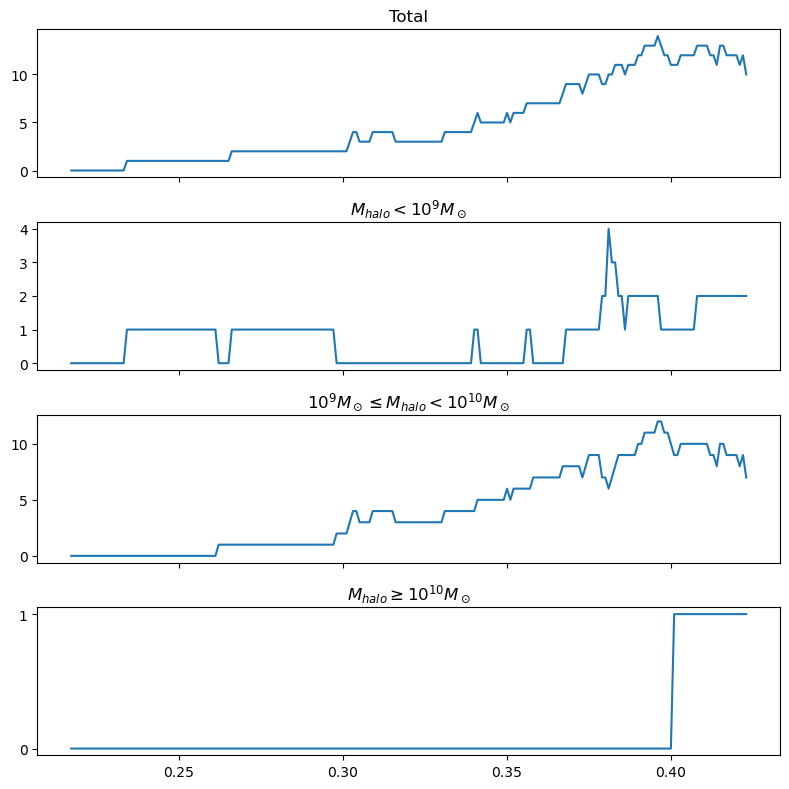

In [59]:
fig, axs = plt.subplots(ncols=1, nrows=4, sharex = True, figsize=(8,8))
axs[0].plot(time, n_halowstars_total)
axs[0].set_title('Total')

axs[1].plot(time, n_halowstars_range1)
axs[1].set_title(r'$M_{halo} < 10^{9} M_\odot$')

axs[2].plot(time, n_halowstars_range2)
axs[2].set_title(r'$10^{9} M_\odot \leq M_{halo} < 10^{10} M_\odot$')

axs[3].plot(time, n_halowstars_range3)
axs[3].set_title(r'$M_{halo} \geq 10^{10} M_\odot$')
axs[3].set_yticks([0,1])

fig.tight_layout()

In [60]:
def halom_sm_sfr(idx):
    halom = []
    sm = []
    sfr =[]
    redshift = ray_tree['0'][idx]['redshift']
    for branch in output_check[idx].keys():
        if output_check[idx][branch]['total_mass'] > 0:
            sm.append(output_check[idx][branch]['total_mass'])
            halom.append(ray_rawtree[branch][int(idx)]['Halo_Mass'])
            sfr.append(output_check[idx][branch]['sfr'])
    return halom, sm, sfr, redshift

In [61]:
halom1, sm1, sfr1, redshift1 = halom_sm_sfr('108')
halom, sm, sfr, redshift = halom_sm_sfr('211')
halom0, sm0, sfr0, redshift0 = halom_sm_sfr('4')

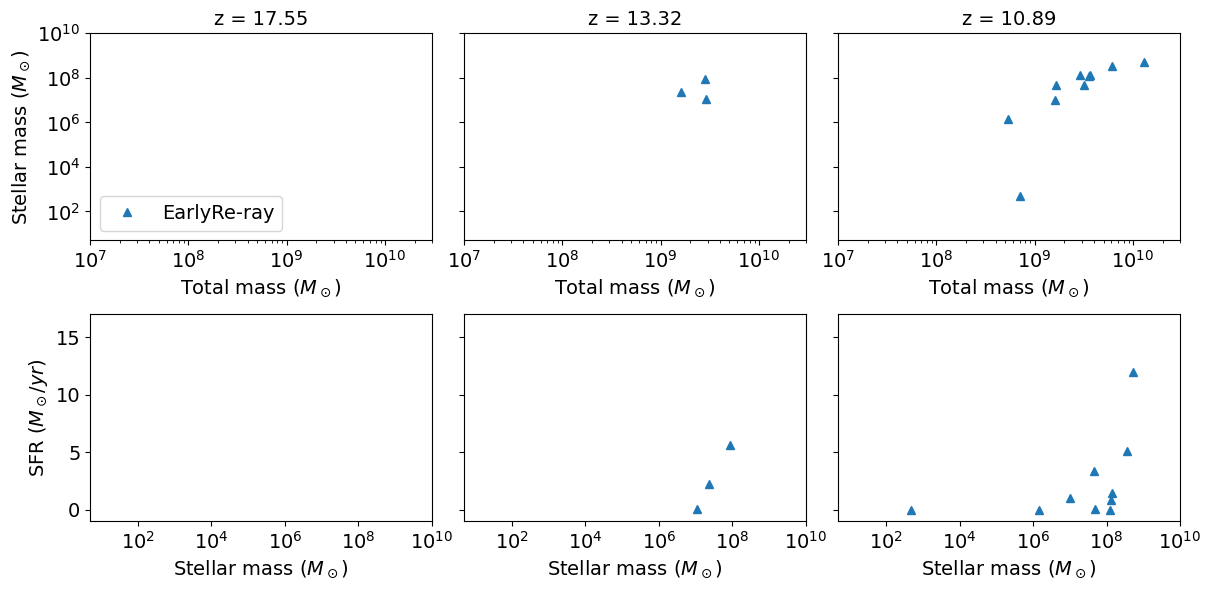

In [62]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharey = 'row', figsize=(12,6))

axs[0,0].plot(halom0, sm0,'^',label='EarlyRe-ray')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_xlabel(r'Total mass ($M_\odot$)', fontsize=14)
axs[0,0].set_ylabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[0,0].set_ylim([0.5e1,1e10])
axs[0,0].set_xlim(1e7,3e10)
axs[0,0].set_title('z = %.2f' % redshift0, fontsize=14)
#plt.xticks([1e6,1e7,1e8,1e9,1e10])
axs[0,0].legend(loc='lower left', fontsize=14)
axs[0,0].tick_params(axis='both', which='major', labelsize=14)

axs[1,0].plot(sm0, sfr0,'^',label='EarlyRe-ray')
axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[1,0].set_ylabel(r'SFR ($M_\odot/yr$)', fontsize=14)
axs[1,0].set_xlim([0.5e1,1e10])
axs[1,0].set_ylim([-1,17])
axs[1,0].tick_params(axis='both', which='major', labelsize=14)

#------------------------------------------------------------------

axs[0,1].plot(halom1, sm1,'^',label='EarlyRe-ray')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlabel(r'Total mass ($M_\odot$)', fontsize=14)
axs[0,1].set_ylim([0.5e1,1e10])
axs[0,1].set_xlim(1e7,3e10)
axs[0,1].set_title('z = %.2f' % redshift1, fontsize=14)
axs[0,1].tick_params(axis='both', which='major', labelsize=14)

axs[1,1].plot(sm1, sfr1,'^',label='EarlyRe-ray')
axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[1,1].set_xlim([0.5e1,1e10])
axs[1,1].set_ylim([-1,17])
axs[1,1].tick_params(axis='both', which='major', labelsize=14)

#------------------------------------------------------------------

axs[0,2].plot(halom, sm,'^',label='EarlyRe-ray')
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].set_xlabel(r'Total mass ($M_\odot$)', fontsize=14)
axs[0,2].set_ylim([0.5e1,1e10])
axs[0,2].set_xlim(1e7,3e10)
axs[0,2].set_title('z = %.2f' % redshift, fontsize=14)
axs[0,2].tick_params(axis='both', which='major', labelsize=14)

axs[1,2].plot(sm, sfr,'^',label='EarlyRe-ray')
axs[1,2].set_xscale('log')
axs[1,2].set_xlabel(r'Stellar mass ($M_\odot$)', fontsize=14)
axs[1,2].set_xlim([0.5e1,1e10])
axs[1,2].set_ylim([-1,17])
axs[1,2].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()

#plt.savefig('/work/hdd/bbvl/tnguyen2/figures/self-shielding/SFR_stellarmass_totalmass_EarlyRe.png', dpi=300)

In [51]:
output_check['100']

{'1': {'ID': array([65333966, 65333967, 65333969, ..., 65440877, 65440878, 65440879]),
  'total_mass': 69602991.58186208,
  'sfr': 4.499585736544708},
 '7': {'ID': array([], dtype=int64), 'total_mass': 0.0, 'sfr': 0.0},
 '0_35': {'ID': array([65363536, 65363537, 65363538, 65363539, 65363540, 65363541,
         65363542, 65363543, 65363546, 65363549, 65363554, 65363555,
         65363558, 65363561, 65363565, 65363572, 65363576, 65363577,
         65363580, 65363587, 65363588, 65363590, 65363593, 65363596,
         65363599, 65363606, 65363607, 65363613, 65363616, 65363619,
         65363621, 65363624, 65363627, 65363636, 65363644, 65363646,
         65363648, 65363650, 65363651, 65363652, 65363653, 65363654,
         65363655, 65363656, 65363657, 65363658, 65363659, 65363660,
         65363661, 65363662, 65363663, 65363664, 65363665, 65363673,
         65363674, 65363683, 65363690, 65363698, 65363706, 65363714,
         65363722, 65363737, 65363738, 65363746, 65363753, 65363760,
       

In [10]:
output['101'].keys()

dict_keys(['1', '7', '0'])

In [10]:
ray_tree['1_22']['75']

{'tree_loc': '1_22',
 'coor': array([0.47356483, 0.50200012, 0.49968263]),
 'Rvir': 0.0017621845302556892,
 'redshift': 14.393940210744,
 'time': 0.2870843688082701,
 'gas_mass': 302999751.91776574,
 'gas_mass_frac': 0.1788584872392928,
 'h2_mass': 30722800.068975758,
 'h2_fraction': 0.1013954627834611,
 'dm_mass': 1370376768.8724527,
 'pop2_mass': 20698815.49721027,
 'pop3_mass': 0.0,
 'star_mass': 20698815.49721027,
 'metal_mass': 84355.03970861924,
 'metallicity': 0.0002783996989261999,
 'sfr': 0.0,
 'total_mass': 1694075336.2874289}

#### Testing each for loop step

In [61]:
idx = '196'
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist()).astype(int)
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])
ds = yt.load(ray_pfs[int(idx)])

if idx == '21':
    ray_ID_all_prev = np.array([])

yt : [INFO     ] 2025-01-02 05:34:59,572 Parameters: current_time              = 19.503658364245
yt : [INFO     ] 2025-01-02 05:34:59,574 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2025-01-02 05:34:59,576 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-02 05:34:59,578 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-02 05:34:59,580 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-02 05:34:59,582 Parameters: current_redshift          = 11.175654555311
yt : [INFO     ] 2025-01-02 05:34:59,583 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2025-01-02 05:34:59,585 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2025-01-02 05:34:59,587 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-02 05:34:59,588 Parameters: hubble_constant           = 0.679


In [62]:
ray_ID_unassign = np.setdiff1d(ray_ID_all, ray_ID_all_prev)
print(ray_ID_unassign)
ray_pos_unassign = ray_pos_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]
ray_vel_unassign = ray_vel_all[np.intersect1d(ray_ID_all, ray_ID_unassign, return_indices=True)[1]]

[65769579 65769581 65769590 65769591 65769592 65769593 65769594 65769595
 65769596 65769597 65769598 65769599 65769603 65769604 65769607 65769608
 65769609 65769611 65769614 65769615 65769618 65769619 65769622 65769624
 65769625 65769626 65769627 65769628 65769629 65769631 65769632 65769635
 65769637 65769638 65769639 65769640 65769641 65769643 65769645 65769646
 65769647 65769649 65769650 65769651 65769652 65769653 65769655 65769656
 65769659 65769660 65769661 65769662 65769663 65769666 65769667 65769669
 65769671 65769672 65769673 65769674 65769675 65769676 65769678 65769680
 65769682 65769683 65769684]


In [63]:
halo_wstars_pos, halo_wstars_rvir, halo_wstars_branch = list_of_halos_wstars_idx(ray_tree, idx)
print(halo_wstars_branch)

['0' '0_14' '0_2' '0_8' '0_10' '0_6' '0_13' '1' '1_8' '3' '3_2' '3_1' '4'
 '4_2' '4_0' '5' '5_0' '6' '8' '8_3' '8_2' '9' '9_1' '9_1_1_0' '9_1_0'
 '20' '69' '69_1']


In [12]:
def find_total_E_multiple(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    if star_pos.shape == (3,):
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    else:
        star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'], axis=1)
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    if star_pos.shape == (3,):
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    else:
        star_relvel_mag = np.linalg.norm(star_vel - halo_vel, axis=1)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden_boolean = char_radius_list > star_r[:,np.newaxis]
    oden = np.array([])
    for j in range(len(oden_boolean)):
        oden = np.append(oden, oden_list[np.where(oden_boolean[j] == True)[0][-1]])
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [13]:
def find_total_E(star_pos, star_vel, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is code_length and the unit of velocity is code_length/s
    star_r_codelength = np.linalg.norm(star_pos - tree[branch][idx]['Halo_Center'])
    star_r = (star_r_codelength*ds.units.code_length).to('m').v
    #
    halo_vel = (tree[branch][idx]['Vel_Com']*ds.units.code_length/ds.units.s).to('m/s').v
    star_relvel_mag = np.linalg.norm(star_vel - halo_vel)
    #Kinetic energy
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [64]:
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
    
ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
halo_boolean_overlap = halo_boolean[overlap_boolean > 1]
ray_ID_indp = ray_ID_unassign[overlap_boolean == 1]
halo_boolean_indp = halo_boolean[overlap_boolean == 1]

for j in range(halo_boolean_indp.shape[1]):
    starmap_ID.append(ray_ID_indp[halo_boolean_indp[:,j]])
    
if len(ray_ID_overlap) > 0:
    print('OVERLAP DETECTED')
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(ray_ID_overlap)):
        overlap_branch = halo_wstars_branch[halo_boolean_overlap[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch, 'with energies', E_list)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])

OVERLAP DETECTED
Star ID 65769579 belong to Branch 9_1_0 with energies [2.27404812e+09 2.31908535e+09 2.04412294e+09 7.04623371e+08]
Star ID 65769581 belong to Branch 9_1_0 with energies [2.27488678e+09 2.31944627e+09 2.04462480e+09 7.14668490e+08]
Star ID 65769590 belong to Branch 1_8 with energies [ 8.63616905e+08 -1.52323347e+09]
Star ID 65769591 belong to Branch 1_8 with energies [ 8.61315863e+08 -1.51637336e+09]
Star ID 65769592 belong to Branch 1_8 with energies [ 8.61467133e+08 -1.51652629e+09]
Star ID 65769593 belong to Branch 1_8 with energies [ 8.61599742e+08 -1.51664657e+09]
Star ID 65769594 belong to Branch 1_8 with energies [ 8.61760352e+08 -1.51678897e+09]
Star ID 65769595 belong to Branch 1_8 with energies [ 8.55008091e+08 -1.50751866e+09]
Star ID 65769596 belong to Branch 1_8 with energies [ 8.61904304e+08 -1.51690079e+09]
Star ID 65769597 belong to Branch 1_8 with energies [ 8.55124601e+08 -1.50772976e+09]
Star ID 65769598 belong to Branch 1_8 with energies [ 8.6204122

In [ ]:
""" Old version before 01/01/2024
#The shape of halo_boolean is (X,Y), where X is the number of star particles and Y is the number of halos with stars
halo_boolean = np.linalg.norm(ray_pos_unassign[:, np.newaxis, :] - halo_wstars_pos, axis=2) <= halo_wstars_rvir
#The number of halos a star particle is in. For example, if this value = 2, the star particle is in the region of 2 halos
overlap_boolean = np.sum(halo_boolean, axis=1) 
#The list of stars in each halo's region
starmap_ID = []
if len(overlap_boolean) > 0 and (overlap_boolean > 1).any() == True:
    print('OVERLAP DETECTED')
    for n in range(len(halo_wstars_branch)):
        starmap_ID.append(np.empty(0))
    ray_pos_overlap = ray_pos_unassign[overlap_boolean > 1]
    ray_vel_overlap = ray_vel_unassign[overlap_boolean > 1]
    ray_ID_overlap = ray_ID_unassign[overlap_boolean > 1]
    #WRITE MORE CODE HERE TO IMPLEMENT THE DETERMINATION OF STARS TO SPECIFIC HALOS
    for k in range(len(halo_boolean)):
        overlap_branch = halo_wstars_branch[halo_boolean[k]]
        E_list = np.array([])
        for branch in overlap_branch:
            E = find_total_E(ray_pos_overlap[k], ray_vel_overlap[k], ds, ray_rawtree, branch, int(idx))
            E_list = np.append(E_list, E)
        bound_branch = overlap_branch[np.argmin(E_list)]
        print('Star ID', ray_ID_overlap[k], 'belong to Branch', bound_branch)
        starmap_ID[list(halo_wstars_branch).index(bound_branch)] = np.append(starmap_ID[list(halo_wstars_branch).index(bound_branch)], ray_ID_overlap[k])
else: #if none of the stars are in overlapped halos
    for j in range(halo_boolean.shape[1]):
        starmap_ID.append(ray_ID_unassign[halo_boolean[:,j]])
"""

In [65]:
i = 24
if len(starmap_ID[i]) > 0: 
    for j in ray_tree[halo_wstars_branch[i]].keys(): #assuming when a star forms inside a halo, it will not leave that halo 
        if int(j) >= int(idx):
            if halo_wstars_branch[i] not in output[j].keys():
                output[j][halo_wstars_branch[i]] = starmap_ID[i]
            else:
                output[j][halo_wstars_branch[i]] = np.append(output[j][halo_wstars_branch[i]], starmap_ID[i])
    if halo_wstars_branch[i].count('_') > 1:
        print('SUB-SUB-BRANCHES DETECTED AT SNAPSHOT', idx)
    nlevels = halo_wstars_branch[i].count('_')
    #for subbranch (or deeper sub-branch), the stars in that sub-branch will belong to the branch at lower level after the two halos merge
    loop_branch = halo_wstars_branch[i]
    for level in range(nlevels):
        deepest_lvl = loop_branch.split('_')[-1]
        mainbranch = loop_branch.split('_' + deepest_lvl)[0]
        merge_timestep = np.max(np.array(list(ray_tree[loop_branch].keys())).astype(int)) + 1
        last_timestep = np.max(np.array(list(ray_tree[mainbranch].keys())).astype(int))
        for j in range(merge_timestep, last_timestep + 1):
            if mainbranch not in output[str(j)].keys():
                output[str(j)][mainbranch] = starmap_ID[i]
            else:
                output[str(j)][mainbranch] = np.append(output[str(j)][mainbranch], starmap_ID[i])
        loop_branch = mainbranch

SUB-SUB-BRANCHES DETECTED AT SNAPSHOT 196


In [71]:
output['210']['9_1_0']

array([65769579, 65769581])

In [31]:
ray_tree['9'].keys()

dict_keys(['158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211'])

In [26]:
ray_tree[halo_wstars_branch[i]].keys()

dict_keys(['47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195',

To do:
+ In a case where one particle belongs to multiple halos, write code to assign that star to a specific halo -> done
+ If a star particle belongs to a sub-branch (for example, '0_20'), add it to the main branch when the halos merge (in the example, add it to branch '0') (done, however, the code doesn't account for sub-sub halos yet (or deeper sub-branches) -> done
+ In the final step, double check whether all stars are located in each halos of all snapshots. If they are not, remove them. -> done -> Should we double check the removed stars to see if they belong to any other halos?


In [342]:
len(output['57']['1'])

269

### Star Assignment Technique using Energy Definition

In [2]:
def univDen(ds):
    # Hubble constant
    H0 = ds.hubble_constant * 100 * u.km/u.s/u.Mpc
    H = H0**2 * (ds.omega_matter*(1 + ds.current_redshift)**3 + ds.omega_lambda)  # Technically H^2
    G = 6.67e-11 * u.m**3/u.s**2/u.kg
    # Density of the universe
    den = (3*H/(8*np.pi*G)).to("kg/m**3") / u.kg * u.m**3
    return den.value

In [3]:
def extract_char_radius(tree, branch, idx):
    oden_list = np.array([100, 150, 200, 250, 300, 500, 700])
    char_radius_list = np.array([])
    for oden in oden_list:
        key = 'r%s' % oden
        char_radius_list = np.append(char_radius_list, tree[branch][idx][key])
    return oden_list, char_radius_list

In [4]:
def find_total_E(star_r, star_relvel_mag, ds, tree, branch, idx):
    #this function calculate the total orbital energy of a star around a halo
    #the unit of position is km and the unit of velocity is km/s
    KE = 0.5*star_relvel_mag**2
    #Approximate M(r < star_r) by using the overdensity
    oden_list, char_radius_list = extract_char_radius(tree, branch, idx)
    char_radius_list = (char_radius_list*ds.units.code_length).to('m').v
    oden = oden_list[char_radius_list > star_r][-1]
    #
    M = (4/3)*np.pi*oden*univDen(ds)*star_r**3
    PE = -G.value*M/star_r
    E = KE + PE
    return E

In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()

In [6]:
idx = 170
branch = '0'

In [7]:
ds = yt.load(ray_pfs[idx])

yt : [INFO     ] 2024-12-13 18:28:03,482 Parameters: current_time              = 18.261035164245
yt : [INFO     ] 2024-12-13 18:28:03,484 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-13 18:28:03,485 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-13 18:28:03,486 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-13 18:28:03,487 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-13 18:28:03,488 Parameters: current_redshift          = 11.722141902049
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-13 18:28:03,489 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-13 18:28:03,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-13 18:28:03,491 Parameters: hubble_constant           = 0.679


In [8]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [32]:
ray_halo_center = ray_rawtree[branch][idx]['Halo_Center']
ray_halo_rvir = ray_rawtree[branch][idx]['Halo_Radius']
ray_halo_vel = ray_rawtree[branch][idx]['Vel_Com']

In [33]:
halo_boolean = np.linalg.norm(ray_pos_all - ray_halo_center, axis=1) < ray_halo_rvir
halo_star_pos = ray_pos_all[halo_boolean]
halo_star_r = np.linalg.norm(halo_star_pos - ray_halo_center, axis=1)
halo_star_r = (halo_star_r*ds.units.code_length).to('m').v
halo_star_vel = ray_vel_all[halo_boolean]
halo_star_relvel_mag = np.linalg.norm(halo_star_vel - ray_halo_vel, axis=1)
halo_star_relvel_mag = (halo_star_relvel_mag*ds.units.km/ds.units.s).to('m/s').v
halo_star_age = ray_age_all[halo_boolean]
halo_star_ID = ray_ID_all[halo_boolean]

In [34]:
E_list = []
for j in range(len(halo_star_r)):
    E_list.append(find_total_E(halo_star_r[j], halo_star_relvel_mag[j], ds, ray_rawtree, branch, idx))
E_list = np.array(E_list)

Text(0.5, 0, 'Distance to Halo Center / Rvir')

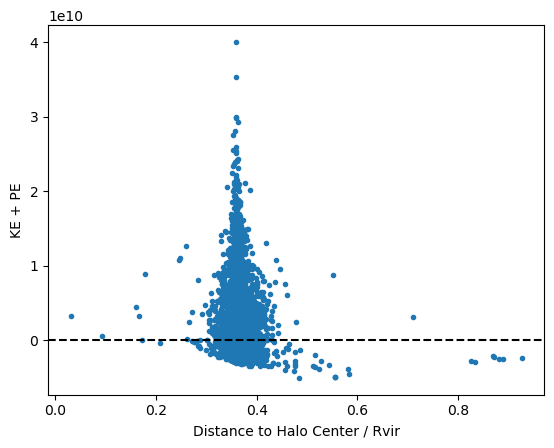

In [35]:
#sns.kdeplot(x = halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), y = E_list, fill=True)
plt.plot(halo_star_r/(ray_halo_rvir*ds.units.code_length).to('m'), E_list, '.')
plt.axhline(0, linestyle='--', color='black')
plt.ylabel('KE + PE')
plt.xlabel('Distance to Halo Center / Rvir')

Only 30% of the stars are bound, which is unlikely. The error may come from the fact that the center of the stellar population is significantly off from the halo center, this introduces errors in the energy calculation. 

Suggestion from Kirk: subtract 

Use peak to determine the group of 

### Star Assignment Technique from AGORA Paper V and VII

Because SHINBAD output doesn't store the maximum circular velocity, we need to estimate it from the circular velocity at the virial radius

In [2]:
def weighted_std(values, weights_list):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights_list)
    N = len(values)
    # Fast and numerically precise:
    variance = np.sum(weights_list*(values-average)**2)/((N-1)*np.sum(weights_list)/N)
    return np.sqrt(variance)

In [3]:
def star_assignment(tree, branch, idx, pfs, sigma_cut = 2, distance_cut = 2):
    ds = yt.load(pfs[int(idx)])
    #
    branch = '0_4'
    halo_center = tree[branch][int(idx)]['Halo_Center']
    halo_rvir = tree[branch][int(idx)]['Halo_Radius']
    halo_mass = tree[branch][int(idx)]['Halo_Mass']
    halo_vel = tree[branch][int(idx)]['Vel_Com']
    halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v
    #
    halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
    halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
    vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir
    #

In [17]:
idx = '194'
ray_pfs = np.loadtxt('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/pfs_allsnaps_1088.txt', dtype=str).tolist()
ds = yt.load(ray_pfs[int(idx)])

yt : [INFO     ] 2024-12-11 16:59:32,587 Parameters: current_time              = 19.408071964245
yt : [INFO     ] 2024-12-11 16:59:32,590 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-11 16:59:32,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-11 16:59:32,595 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-11 16:59:32,597 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-11 16:59:32,600 Parameters: current_redshift          = 11.215615860209
yt : [INFO     ] 2024-12-11 16:59:32,602 Parameters: omega_lambda              = 0.6935
yt : [INFO     ] 2024-12-11 16:59:32,604 Parameters: omega_matter              = 0.3065
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-11 16:59:32,607 Parameters: hubble_constant           = 0.679


In [5]:
ray_rawtree = np.load('/scratch/bbvl/gtg115x/new_zoom_5/box_2_z_1/halotree_1088_final.npy', allow_pickle=True).tolist()

In [18]:
branch = '0'
halo_center = ray_rawtree[branch][int(idx)]['Halo_Center']
halo_rvir = ray_rawtree[branch][int(idx)]['Halo_Radius']
halo_mass = ray_rawtree[branch][int(idx)]['Halo_Mass']
halo_vel = ray_rawtree[branch][int(idx)]['Vel_Com']
halo_vel = (halo_vel*ds.units.code_length/ds.units.s).to('km/s').v

halo_rvir_si = ((halo_rvir*ds.units.code_length).to('m').v)*u.m
halo_mass_si = ((halo_mass*ds.units.Msun).to('kg').v)*u.kg
vcir = np.sqrt(G*halo_mass_si/halo_rvir_si).to('km/s').value #this is the circular velocity at r = Rvir

In [19]:
ray_metadata = np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_metadata_allbox_%s.npy' % idx, allow_pickle=True).tolist()
ray_pos_all = ray_metadata['pos']
ray_age_all = ray_metadata['age']
ray_mass_all = ray_metadata['mass']
ray_ID_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_ID_allbox_%s.npy' % idx, allow_pickle=True).tolist())
ray_vel_all = np.array(np.load('/work/hdd/bbvl/gtg115x/new_zoom_5/box_2_z_1/star_metadata/star_vel_allbox_%s.npy' % idx, allow_pickle=True).tolist()['vel'])

In [20]:
#Identify all the stars within the halo region
inreg_bool = np.linalg.norm(ray_pos_all - halo_center, axis=1) < halo_rvir
inreg_pos = ray_pos_all[inreg_bool]
inreg_r = np.linalg.norm(inreg_pos - halo_center, axis=1)
#
inreg_vel = ray_vel_all[inreg_bool]
inreg_relvel = inreg_vel - halo_vel
inreg_relvelmag = np.linalg.norm(inreg_relvel, axis=1)
#
inreg_ID = ray_ID_all[inreg_bool]
inreg_mass = ray_mass_all[inreg_bool]

In [21]:
sigma_cut = 2
distance_cut = 2

In [22]:
reduced_bool = np.logical_and(inreg_r < 0.8*halo_rvir, inreg_relvelmag < 4*vcir)
reduced_mass = inreg_mass[reduced_bool]
reduced_pos = inreg_pos[reduced_bool]
reduced_com = np.average(reduced_pos, weights=reduced_mass, axis=0)
#
reduced_vel = inreg_vel[reduced_bool]
reduced_relvel = reduced_vel - np.average(reduced_vel, weights=reduced_mass, axis=0)
reduced_relvelmag = np.linalg.norm(reduced_relvel, axis=1)
sigma_vel = weighted_std(reduced_relvelmag, weights_list=reduced_mass)
#
reduced_ID = inreg_ID[reduced_bool]

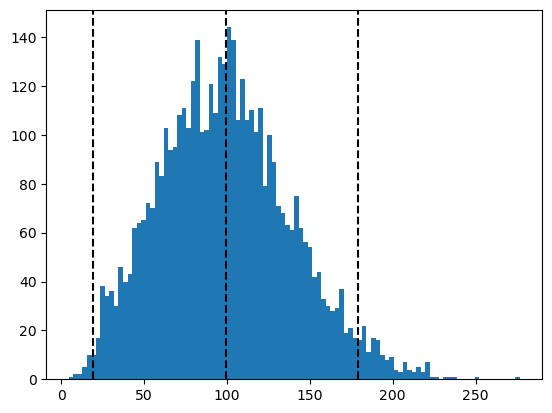

In [11]:
plt.hist(reduced_relvelmag, bins=100)
plt.axvline(np.average(reduced_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) - sigma_cut*sigma_vel, color='k', linestyle='--')
plt.axvline(np.average(reduced_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

In [23]:
def cal_R90(pos, center, mass):
    r = np.linalg.norm(pos - center, axis=1)
    r_sort = r[np.argsort(r)]
    mass_sort = mass[np.argsort(r)]
    mass_cumsum = np.cumsum(mass_sort)
    mass_cumsumpercent = mass_cumsum/mass_cumsum[-1]
    R90 = r_sort[np.where(mass_cumsumpercent > 0.9)[0][0]]
    return R90

In [24]:
r90_halocenter = cal_R90(reduced_pos, halo_center, reduced_mass)
r90_starcenter = cal_R90(reduced_pos, reduced_com, reduced_mass)

In [25]:
reduced2_bool = (np.linalg.norm(reduced_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                (np.linalg.norm(reduced_pos - reduced_com, axis=1) < distance_cut*r90_starcenter) & \
                (reduced_relvelmag <= np.average(reduced_relvelmag) + sigma_cut*sigma_vel)
reduced2_pos = reduced_pos[reduced2_bool]
reduced2_mass = reduced_mass[reduced2_bool]
reduced2_ID = reduced_ID[reduced2_bool]
reduced2_vel = reduced_vel[reduced2_bool]
reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)

In [26]:
counter = 0
while np.sum(reduced2_bool)/len(reduced2_bool) <= 0.99:
    if len(reduced2_pos) == 0:
        reduced2_com = np.nan
        break
    reduced2_relvel = reduced2_vel - np.average(reduced2_vel, weights=reduced2_mass, axis=0)
    reduced2_relvelmag = np.linalg.norm(reduced2_relvel, axis=1)
    #
    sigma_vel = weighted_std(reduced2_relvelmag, weights_list=reduced2_mass)
    r90_halocenter = cal_R90(reduced2_pos, halo_center, reduced2_mass)
    r90_starcenter = cal_R90(reduced2_pos, reduced2_com, reduced2_mass)
    #
    reduced2_bool = (np.linalg.norm(reduced2_pos - halo_center, axis=1) < distance_cut*r90_halocenter) & \
                    (np.linalg.norm(reduced2_pos - reduced2_com, axis=1) < distance_cut*r90_starcenter) & \
                    (reduced2_relvelmag <= np.average(reduced2_relvelmag) + sigma_cut*sigma_vel)
    reduced2_pos = reduced2_pos[reduced2_bool]
    reduced2_mass = reduced2_mass[reduced2_bool]
    reduced2_ID = reduced2_ID[reduced2_bool]
    reduced2_vel = reduced2_vel[reduced2_bool]
    reduced2_com = np.average(reduced2_pos, weights=reduced2_mass, axis=0)
    counter += 1
    print(counter)

1
2
3


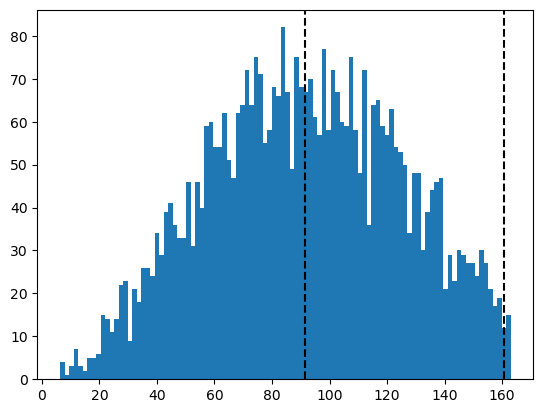

In [19]:
plt.hist(reduced2_relvelmag, bins=100)
plt.axvline(np.average(reduced2_relvelmag), color='k', linestyle='--')
plt.axvline(np.average(reduced2_relvelmag) + sigma_cut*sigma_vel, color='k', linestyle='--')

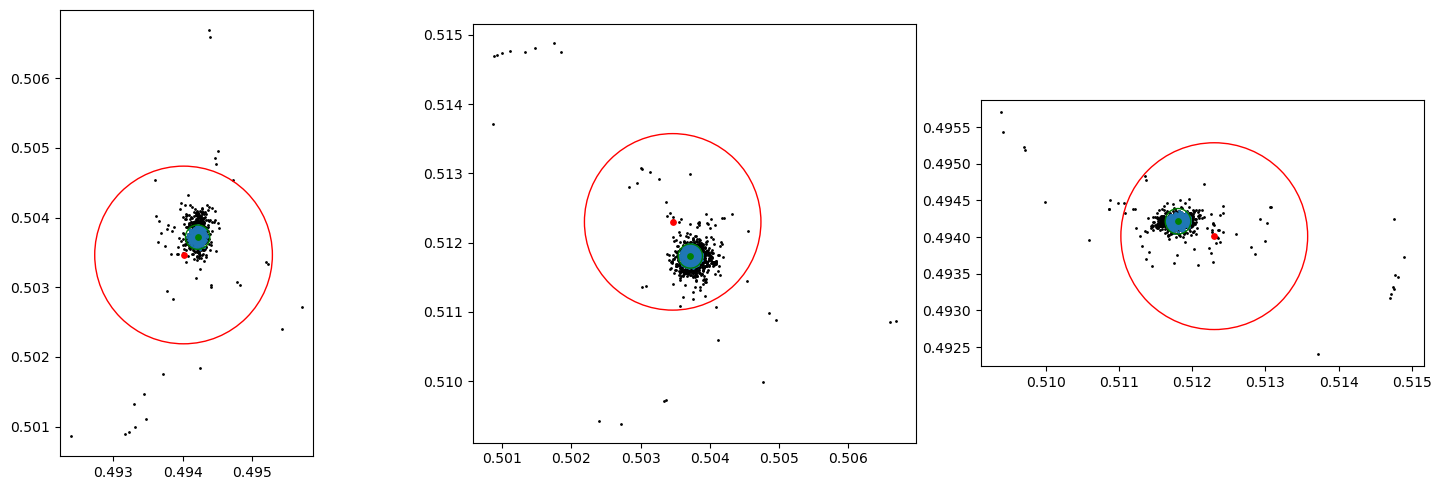

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

axs[0].scatter(inreg_pos[:,0], inreg_pos[:,1], s=1, color='black')

axs[0].scatter(reduced2_pos[:,0], reduced2_pos[:,1], s=1)

axs[0].scatter(halo_center[0], halo_center[1], color='red', s=15)
circle1 = plt.Circle((halo_center[0], halo_center[1]), distance_cut*r90_halocenter, color='red', fill=False)
axs[0].add_patch(circle1)

axs[0].scatter(reduced2_com[0], reduced2_com[1], color='green', s=15)
circle2 = plt.Circle((reduced2_com[0], reduced2_com[1]), distance_cut*r90_starcenter, color='green', fill=False)
axs[0].add_patch(circle2)

axs[0].set_aspect('equal')

#---------------------------------------------------------
axs[1].scatter(inreg_pos[:,1], inreg_pos[:,2], s=1, color='black')

axs[1].scatter(reduced2_pos[:,1], reduced2_pos[:,2], s=1)

axs[1].scatter(halo_center[1], halo_center[2], color='red', s=15)
circle1 = plt.Circle((halo_center[1], halo_center[2]), distance_cut*r90_halocenter, color='red', fill=False)
axs[1].add_patch(circle1)

axs[1].scatter(reduced2_com[1], reduced2_com[2], color='green', s=15)
circle2 = plt.Circle((reduced2_com[1], reduced2_com[2]), distance_cut*r90_starcenter, color='green', fill=False)
axs[1].add_patch(circle2)

axs[1].set_aspect('equal')
#---------------------------------------------------------
axs[2].scatter(inreg_pos[:,2], inreg_pos[:,0], s=1, color='black')

axs[2].scatter(reduced2_pos[:,2], reduced2_pos[:,0], s=1)

axs[2].scatter(halo_center[2], halo_center[0], color='red', s=15)
circle1 = plt.Circle((halo_center[2], halo_center[0]), distance_cut*r90_halocenter, color='red', fill=False)
axs[2].add_patch(circle1)

axs[2].scatter(reduced2_com[2], reduced2_com[0], color='green', s=15)
circle2 = plt.Circle((reduced2_com[2], reduced2_com[0]), distance_cut*r90_starcenter, color='green', fill=False)
axs[2].add_patch(circle2)

axs[2].set_aspect('equal')

fig.tight_layout()